# Case Study Projesi: Kardiyovasküler Hastalık Tahmini
---

## Proje Açıklaması
Bu projede, kardiyovasküler hastalıkları tahmin etmek için bir makine öğrenmesi modeli geliştirilecektir. Verilen veri seti, çeşitli hasta özelliklerini ve bu hastaların kardiyovasküler hastalık durumu hakkında bilgi içermektedir. Amaç, bu veri setini kullanarak hastalık tahmin doğruluğunu artırmak için gerekli veri işleme ve özellik mühendisliği adımlarını gerçekleştirmektir.

---

Kullanılacak veri seti: [Heart Disease Dataset](https://archive.ics.uci.edu/dataset/45/heart+disease)

Kurulum:
```pip install ucimlrepo```

Kullanım:
```
from ucimlrepo import fetch_ucirepo 
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
# data (as pandas dataframes) 
X = heart_disease.data.features 
y = heart_disease.data.targets 
# metadata 
print(heart_disease.metadata) 
# variable information 
print(heart_disease.data.variables)
heart_disease.variables)
```

**Veri setinin Özelliklerinin açıklamaları:**

1. **Age: Yaş** - Kişinin yaşı hakkında sayısal bilgi içerir.
2. **Sex: Cinsiyet** - Kişinin cinsiyetini belirtir (1 = erkek; 0 = kadın).
3. **Chest Pain Type (4 values)** - Göğüs ağrısı türünü belirtir (1: Tipik angina, 2: Atipik angina, 3: Non-anginal ağrı, 4: Asemptomatik).
4. **Resting Blood Pressure** - Dinlenme halindeki kan basıncı (mm Hg cinsinden).
5. **Serum Cholesterol in mg/dl** - Serum kolesterol düzeyi (mg/dl cinsinden).
6. **Fasting Blood Sugar > 120 mg/dl** - Açlık kan şekeri seviyesi 120 mg/dl'nin üzerinde mi (1 = doğru; 0 = yanlış).
7. **Resting ECG results (values 0, 1, 2)** - Dinlenme halindeki elektrokardiyografi sonuçları (0: Normal, 1: ST-T dalga anormallikleri, 2: Sol ventrikül hipertrofisi veya T dalga inversiyonu).
8. **Maximum Heart Rate achieved** - Ulaşılan maksimum kalp hızı.
9. **Exercise Induced Angina** - Egzersizle indüklenen angina (1 = evet; 0 = hayır).
10. **ST depression induced by exercise relative to rest** - Egzersizle indüklenen ST segmenti depresyonu (dinlenmeye göre).
11. **Slope of the peak exercise ST segment** - Egzersiz sırasında zirve ST segmentinin eğimi (1: Yukarı eğimli, 2: Düz, 3: Aşağı eğimli).
12. **Number of major vessels (0-3) colored by fluoroscopy** - Floroskopi ile boyanmış ana damar sayısı (0-3 arası).
13. **Thal** - Talasemi durumu (3 = normal; 6 = sabit defekt; 7 = geri dönebilen defekt).

---

**Hedef değişken**: Presence of heart disease (Kalp hastalığı varlığı) - Kalp hastalığı olup olmadığını belirtir (1 = hastalık; 0 = hastalık yok).


---

**Sayısal ve kategorik özellikler**

**Sayısal özellikler**
- age: integer
- resting_blood_pressure: integer
- serum_cholesterol: integer
- maximum_heart_rate_achived
- st_depression_induced_by_exercise
- number_major_vessels

**Sayısal kategorik özellikler**
- sex
- chest_pain_type
- fasting_blood_sugar
- resting_ecg_results
- exercise_induced_angina
- thal
- slope_peak_exercise_st_segment
- presence_of_heart_disease (Target)


**Kütüphane importları**

In [72]:
import warnings
from ucimlrepo import fetch_ucirepo 
warnings.filterwarnings("ignore")
%matplotlib inline
import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split,StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, roc_auc_score, roc_curve,auc, confusion_matrix, make_scorer
from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', None)
plt.style.use("ggplot")
sns.set_palette(sns.diverging_palette(220, 20))

# Veri Yükleme ve Temizleme

- İlk olarak veri kaynaktan indirilmiş, ardından özellikler proje word dosyasında bulunan özellikler ile karşılaştırılıp doğrulanmış ve özelliklere proje word dosyasındaki özellik isimleri verilmiştir.
  
- Kaynaktan gelen veriler dataframe haline getirilmiştir. Kolon isimlendirmeleri yapıldıktan sonra tekrar raw_df adında csv dosyasına kaydedilmiştir. Buradaki amaç, notebook dosyasının baştan çalıştırması durumunda veriyi internetten tekrar indirmek yerine csv den okumaktır.

- Dataseti indirme

In [73]:
# heart_disease = fetch_ucirepo(id=45)
# X = heart_disease.data.features 
# y = heart_disease.data.targets 
# df = pd.concat([X, y], axis=1)
# print("Veri seti boyutu")
# print(heart_disease.data.features.shape)
# print(heart_disease.data.targets.shape)
# print("---------------------------------")
# print("İnternetten okunan verinin kolon isimleri ve tipleri:")
# print(df.info())

- Word dosyasındaki isimlendirme ile csv kayıt işlemi

In [74]:
# columns_rename_dict={
#     "age":"age",
#     "sex":"sex",
#     "cp":"chest_pain_type",
#     "trestbps":"resting_blood_pressure",
#     "chol":"serum_cholesterol",
#     "fbs":"fasting_blood_sugar",
#     "restecg":"resting_ecg_results",
#     "thalach":"maximum_heart_rate_achieved",
#     "exang":"exercise_induced_angina",
#     "oldpeak":"st_depression_induced_by_exercise",
#     "slope":"slope_peak_exercise_st_segment",
#     "ca":"number_major_vessels",
#     "thal":"thal",
#     "num":"presence_of_heart_disease"
# }
# df = df.rename(columns=columns_rename_dict)

# # hedef değişken binary tipe dönüştürüldü.
# df["presence_of_heart_disease"] = np.where(df["presence_of_heart_disease"] > 1, 1, 0)
# df.to_csv("raw_heart_disease_data.csv", index=False)

**num yani Presence of heart disease hedef değişkeni 5 klasdan oluşmaktadır. Canlı dersde bu değişkenin 0 ve 1 olarak değerlendirilmesi istendiği. Bu nedenle 1 üzerindeki değerlerinde yine 1 olarak alınacağı belirtildiğinden dolayı hedef  bu şekilde düzenlenmiştir.**

**Verinin lokalden yüklenmesi**

In [75]:
df = pd.read_csv("raw_heart_disease_data.csv")
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                303 non-null    int64  
 1   sex                                303 non-null    int64  
 2   chest_pain_type                    303 non-null    int64  
 3   resting_blood_pressure             303 non-null    int64  
 4   serum_cholesterol                  303 non-null    int64  
 5   fasting_blood_sugar                303 non-null    int64  
 6   resting_ecg_results                303 non-null    int64  
 7   maximum_heart_rate_achieved        303 non-null    int64  
 8   exercise_induced_angina            303 non-null    int64  
 9   st_depression_induced_by_exercise  303 non-null    float64
 10  slope_peak_exercise_st_segment     303 non-null    int64  
 11  number_major_vessels               299 non-null    float64

**Eksik Veri İşlemleri**
- number_major_vessels de 4 ve thal da 2 adet eksik veri tespit edilmiştir.
- Bir veri setinde bulunan eksik veriler için dünyada kabul gören %5 kuralına göre eksik veriler veri setinin %5 inden az ise bu verileri kaldırmak genelde uygulanan bir yaklaşımdır.



- Heart-disease veri setinde bu oran yaklaşık 1.98 olduğundan eksik veriler temizleniştir.
$$
\text{Eksik veri oranı} = \left(\frac{6}{303}\right) \times 100 \approx 1.98\%
$$


<Axes: >

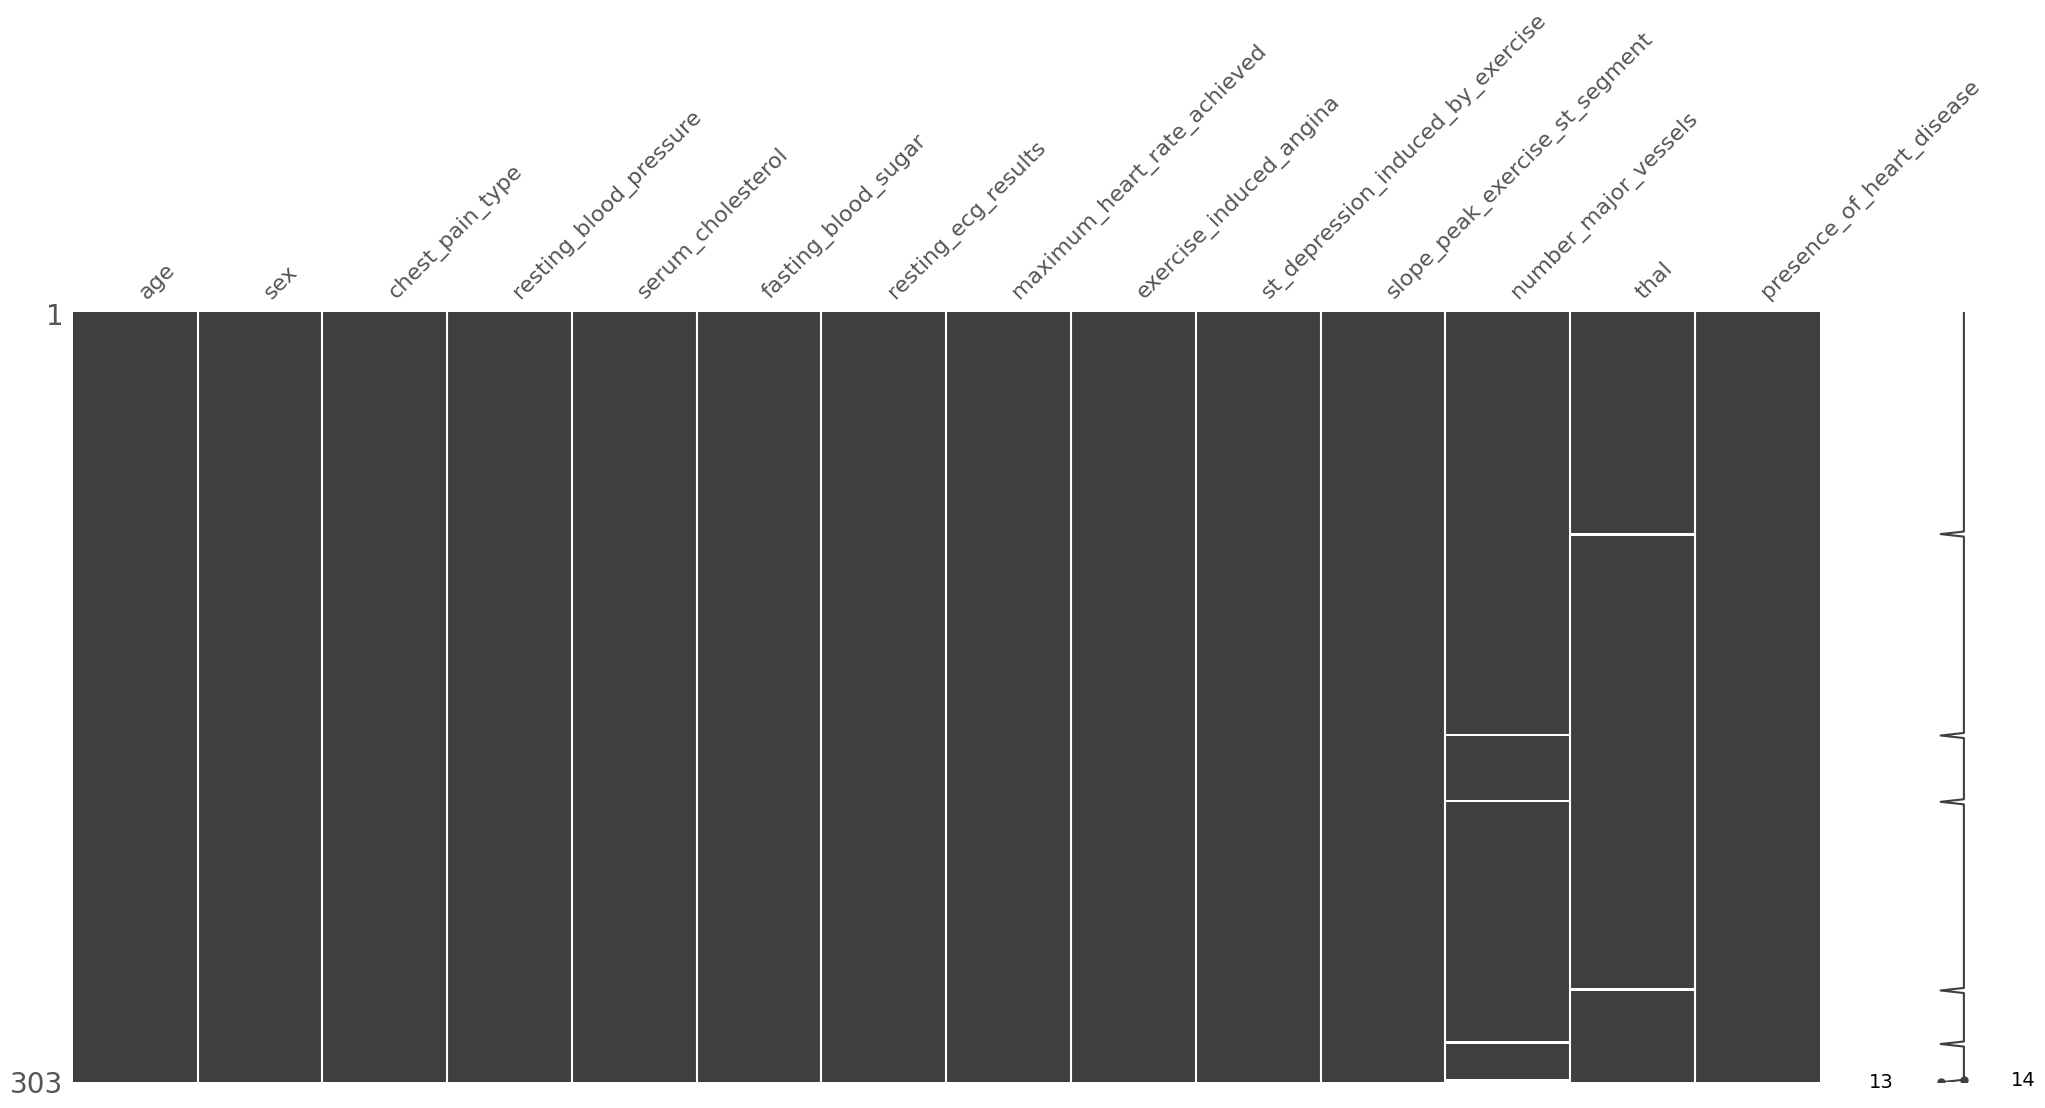

In [77]:
msno.matrix(df)

In [78]:
df.isnull().sum()

age                                  0
sex                                  0
chest_pain_type                      0
resting_blood_pressure               0
serum_cholesterol                    0
fasting_blood_sugar                  0
resting_ecg_results                  0
maximum_heart_rate_achieved          0
exercise_induced_angina              0
st_depression_induced_by_exercise    0
slope_peak_exercise_st_segment       0
number_major_vessels                 4
thal                                 2
presence_of_heart_disease            0
dtype: int64

- Eksik verilerin temizlenmesi

In [79]:
df.dropna(inplace=True)
df.isnull().sum()

age                                  0
sex                                  0
chest_pain_type                      0
resting_blood_pressure               0
serum_cholesterol                    0
fasting_blood_sugar                  0
resting_ecg_results                  0
maximum_heart_rate_achieved          0
exercise_induced_angina              0
st_depression_induced_by_exercise    0
slope_peak_exercise_st_segment       0
number_major_vessels                 0
thal                                 0
presence_of_heart_disease            0
dtype: int64

**Tekrarlanan veri kontrolü**
- Veri setinde tekrarlanan veri bulunmamaktadır.

In [80]:
df[df.duplicated(keep=False)]

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease


**Anormal değerlerin tespiti**

- Anormal değerlerin tespiti işleminden önce plotting fonksiyonu tanımlanmış veriler analiz edilmiştir.
  
- Veri setinde object veya categorical tipde veri olmadığından. Sayısal verileri görselleştirmek amaçlı yazılmıştır. Dağılımlar için histogram ve kdeplot, aykırı değer tespiti için boxplot çizimi yapılmaktadır.
  
- Dağılımlar incelenmiştir.
  
- Anormal değerlerin tespiti için fonksiyon yazılmıştır. Veri setindeki her bir sayısal özellik için girilen eşik değere göre alt ve üst limitleri geri dönmektedir. Ayrıca describe ve outliers i göstermek için kolaylaştırıcı fonksiyonlar yazılmıştır.
  
-  Tespit edilen aykırı değerler alt limit yada üst limit değerlerine baskılanmıştır.
  
-  Sayısal kategorik değişkenlerin sınıfları veri setinden kontrol edilip doğrulamaları yapılmıştır.

**Fonksiyon tanımlamaları**

In [81]:
def plot_features(df,types=["int64","float64"]):
   numeric_columns= [col for col in df.columns if df[col].dtype in types]
   for i in numeric_columns:
      fig, axes = plt.subplots(nrows=1,ncols=3, figsize=(20,4))
      sns.histplot(x=df[i],bins=10,ax=axes[0])
      axes[0].set_title(i)
      sns.boxplot(x=df[i],ax=axes[1])
      axes[1].set_title(i)
      sns.kdeplot(x=df[i],ax=axes[2])
      axes[2].set_title(i)
      plt.show()

- Diğer plot fonksiyonuda barplotun özelleştirilmiş halidir kategorik bir özelliğin sayısal bir özelliğe karşı durumunu görselleştirmektedir.

In [82]:
def custom_barplot(df, categoric_value, numeric_value, agg_func):
    sorted_df = df.groupby(categoric_value)[numeric_value].agg(agg_func).reset_index().sort_values(numeric_value, ascending=False)
    sns.barplot(x=categoric_value, y=numeric_value, data=df, estimator=agg_func, order=sorted_df[categoric_value], ci=False)
    plt.xticks(rotation=90)
    plt.show()
    return sorted_df

In [83]:
def outlier_thresholds(df, variable, q1_thr=0.25, q3_thr=0.75):
    quartile1 = df[variable].quantile(q1_thr)
    quartile3 = df[variable].quantile(q3_thr)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    print(f"low_limit: {low_limit}, up_limit: {up_limit}")
    return low_limit, up_limit

In [84]:
def describe_feature(df, feature):
    print(f"Veri tipi: {df[feature].dtypes}")
    return df[[feature]].describe().T

In [85]:
def describe_categorical_feature(df, feature, normalize=False):
    print(f"Veri tipi: {df[feature].dtypes}")
    return df[feature].value_counts(normalize=normalize).reset_index()

In [86]:
def show_outliers(df, feature, low_limit, up_limit, head_num = 5):
    df = df[(df[feature] < low_limit) | (df[feature] > up_limit)]
    print(f"Veri setinde {len(df)} adet aykırı değer bulunmaktadır.")
    return df.head(head_num)

**Sayısal özellikler**

In [87]:
numeric_features = [
    "age",
    "resting_blood_pressure",
    "serum_cholesterol",
    "maximum_heart_rate_achieved",
    "st_depression_induced_by_exercise",
    "number_major_vessels"
]

In [88]:
df[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
resting_blood_pressure,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
serum_cholesterol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
maximum_heart_rate_achieved,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
st_depression_induced_by_exercise,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2
number_major_vessels,297.0,0.676768,0.938965,0.0,0.0,0.0,1.0,3.0


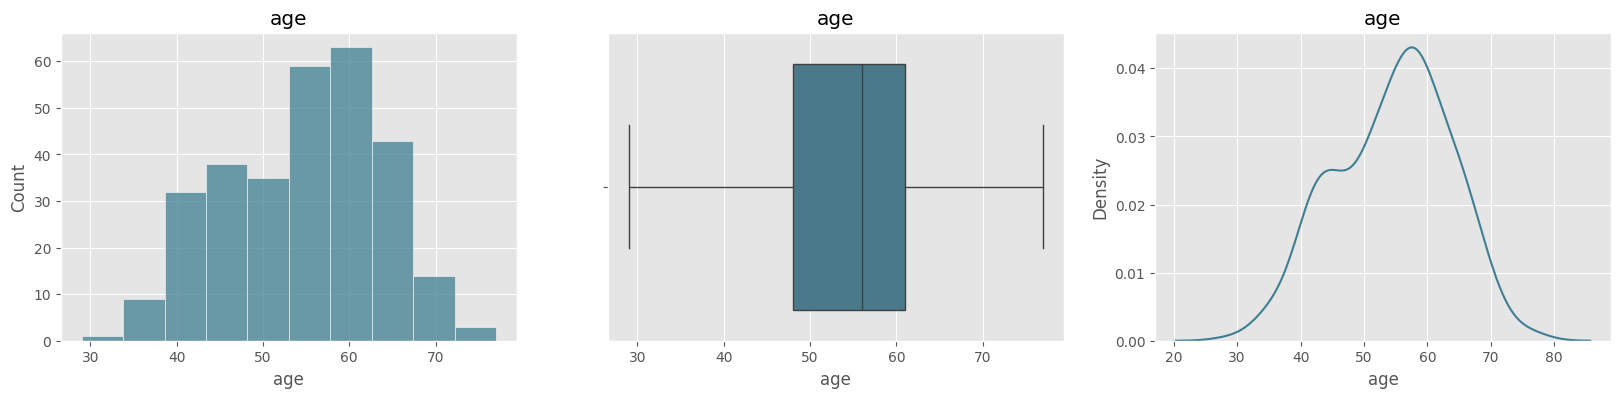

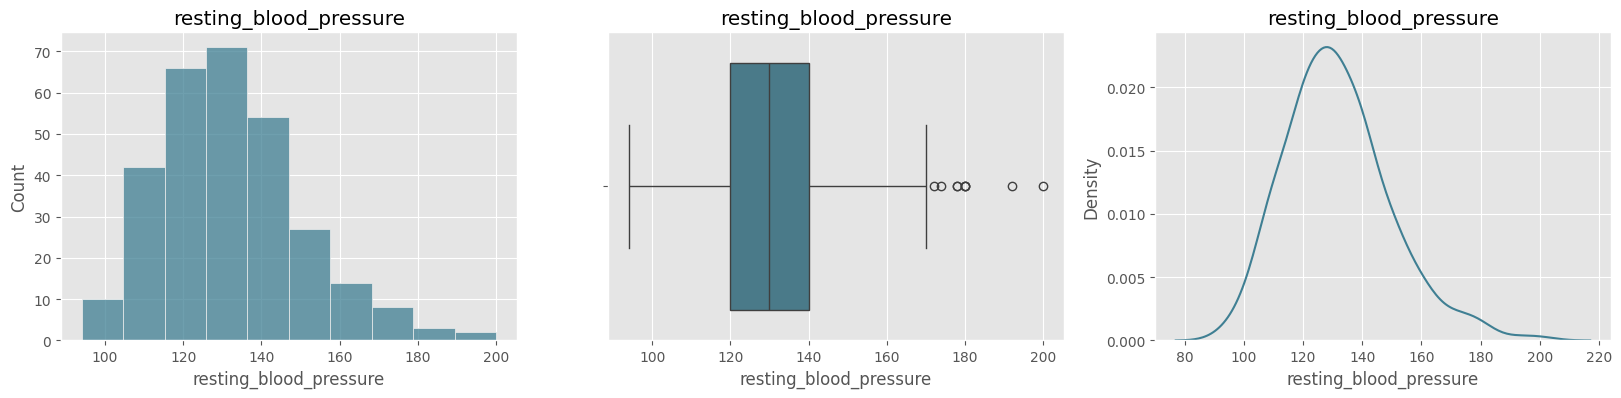

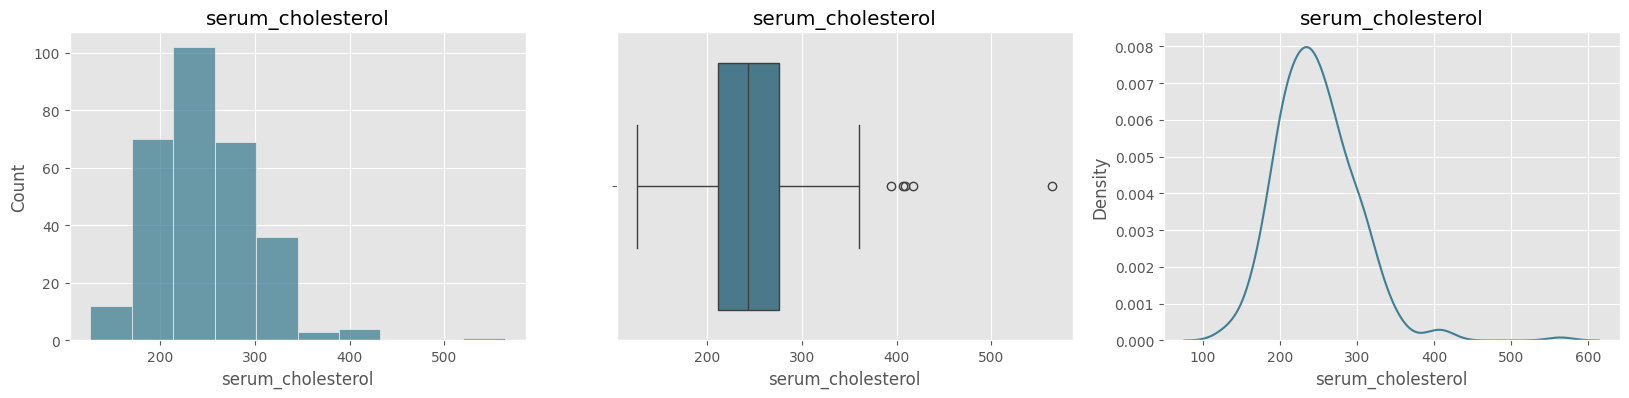

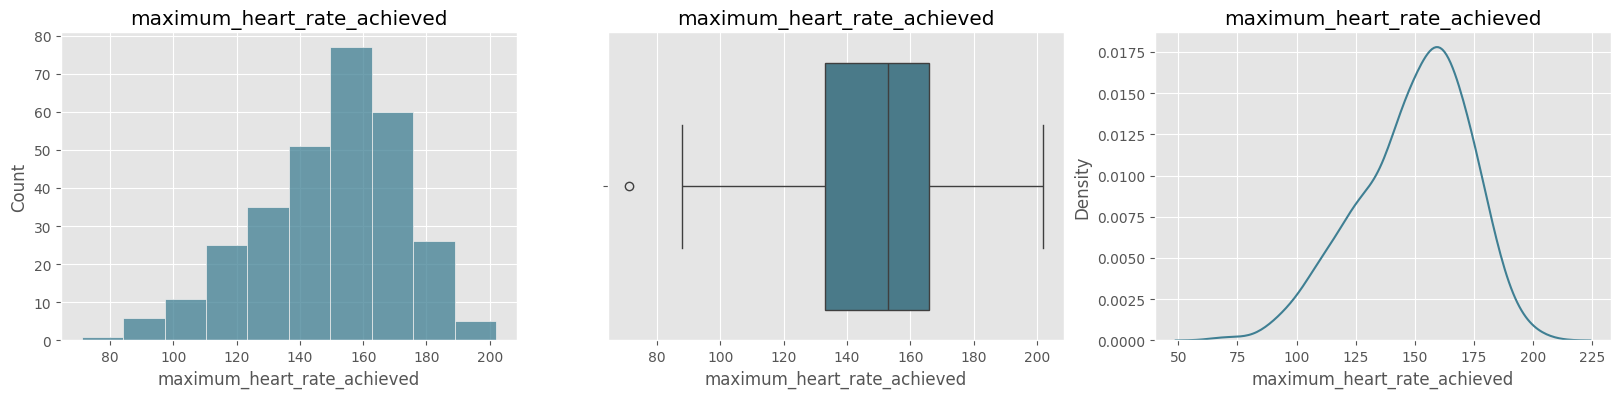

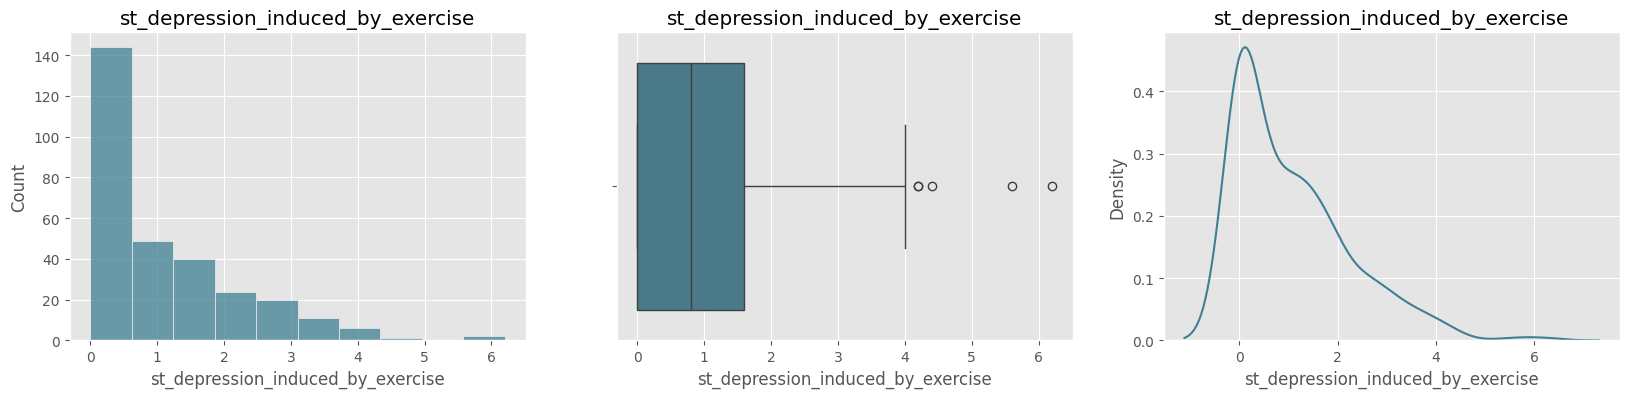

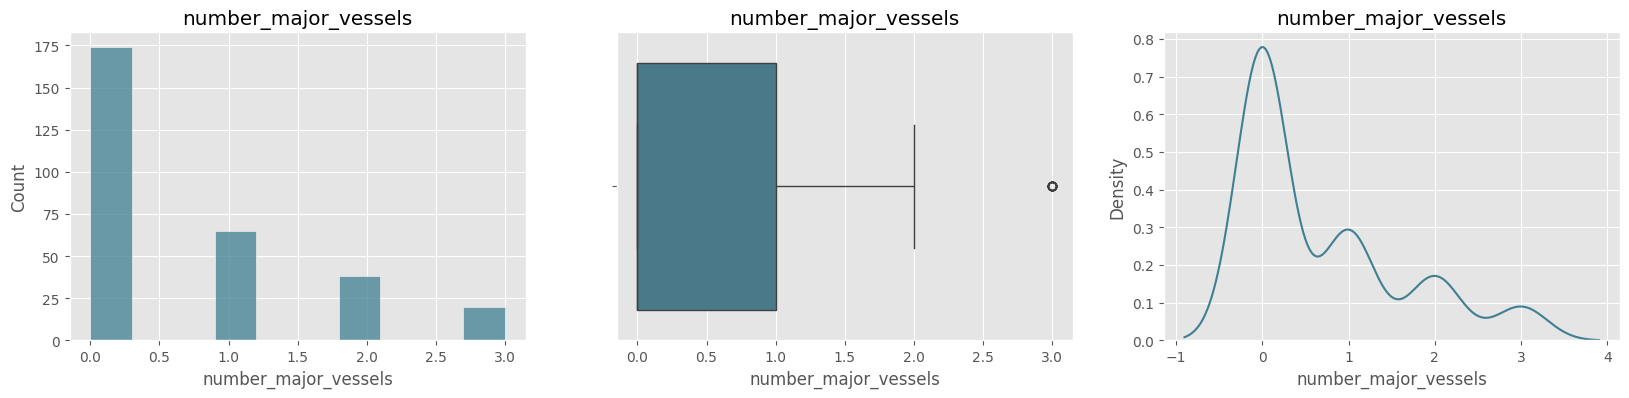

In [89]:
plot_features(df[numeric_features])

**Dağılımlar incelendiğinde age, resting bolood pressure özelliklerinin normale yakın dağıldığı, serum cholesterolun hafif sağa çarpık olduğu, maximum healt rate achived hafif sola çarpık olduğu, st_depression induced by exercise yüksek oranda sağa çarpık olduğu gözlemlenmiştir.**

**Değişkenlerin özet istatistikleri mean ve medyan değerleri incelendiğindede bu durum gözlenmektedir.**

**Age**

- Age değişkenindeki değerler normal görünmektedir aykırı değer bulunmamaktadır.

In [90]:
describe_feature(df, "age")

Veri tipi: int64


,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0


In [91]:
low_limit, up_limit = outlier_thresholds(df, "age")
show_outliers(df,"age", low_limit, up_limit)

low_limit: 28.5, up_limit: 80.5
Veri setinde 0 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease


**Resting blood pressure**

- Üst limit değerinin üzerinde 9 adet aykırı değer tespit edilmiş ve üst limit değerine baskılanmıştır.

In [92]:
describe_feature(df,"resting_blood_pressure")

Veri tipi: int64


,count,mean,std,min,25%,50%,75%,max
resting_blood_pressure,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0


In [93]:
low_limit, up_limit = outlier_thresholds(df, "resting_blood_pressure")
show_outliers(df,"resting_blood_pressure", low_limit, up_limit)

low_limit: 90.0, up_limit: 170.0
Veri setinde 9 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
14,52,1,3,172,199,1,0,162,0,0.5,1,0.0,7.0,0
83,68,1,3,180,274,1,2,150,1,1.6,2,0.0,7.0,1
126,56,0,4,200,288,1,2,133,1,4.0,3,2.0,7.0,1
172,59,0,4,174,249,0,0,143,1,0.0,2,0.0,3.0,0
183,59,1,1,178,270,0,2,145,0,4.2,3,0.0,7.0,0


In [94]:
# Aykırı değer baskılama.
df.loc[(df["resting_blood_pressure"] > up_limit), "resting_blood_pressure"] = up_limit
show_outliers(df,"resting_blood_pressure", low_limit, up_limit)

Veri setinde 0 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease


**serum_cholesterol**

- Üst limit değerinin üzerinde 5 adet aykırı değer tespit edilmiş ve üst limit değerine baskılanmıştır.

In [95]:
describe_feature(df,"serum_cholesterol")

Veri tipi: int64


,count,mean,std,min,25%,50%,75%,max
serum_cholesterol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0


In [96]:
low_limit, up_limit = outlier_thresholds(df, "serum_cholesterol")
show_outliers(df,"serum_cholesterol", low_limit, up_limit)

low_limit: 113.5, up_limit: 373.5
Veri setinde 5 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
48,65,0,3,140,417,1,2,157,0,0.8,1,1.0,3.0,0
121,63,0,4,150,407,0,2,154,0,4.0,2,3.0,7.0,1
152,67,0,3,115,564,0,2,160,0,1.6,2,0.0,7.0,0
173,62,0,4,140,394,0,2,157,0,1.2,2,0.0,3.0,0
181,56,0,4,134,409,0,2,150,1,1.9,2,2.0,7.0,1


In [97]:
# Aykırı değer baskılama.
df.loc[(df["serum_cholesterol"] > up_limit), "serum_cholesterol"] = up_limit
show_outliers(df,"serum_cholesterol", low_limit, up_limit)

Veri setinde 0 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease


**maximum_heart_rate_achieved**

- Alt limit değerinin altında 1 adet aykırı değer tespit edilmiş ve alt limit değerine baskılanmıştır.

In [98]:
describe_feature(df,"maximum_heart_rate_achieved")

Veri tipi: int64


,count,mean,std,min,25%,50%,75%,max
maximum_heart_rate_achieved,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0


In [99]:
low_limit, up_limit = outlier_thresholds(df, "maximum_heart_rate_achieved")
show_outliers(df,"maximum_heart_rate_achieved", low_limit, up_limit)

low_limit: 83.5, up_limit: 215.5
Veri setinde 1 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
245,67,1,4,120,237.0,0,0,71,0,1.0,2,0.0,3.0,1


In [100]:
# Aykırı değer baskılama.
df.loc[(df["maximum_heart_rate_achieved"] < low_limit), "maximum_heart_rate_achieved"] = low_limit
show_outliers(df,"maximum_heart_rate_achieved", low_limit, up_limit)

Veri setinde 0 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease


**st_depression_induced_by_exercise**

- Üst limit değerinin üzerinde 5 adet aykırı değer tespit edilmiş ve üst limit değerine baskılanmıştır.

In [101]:
describe_feature(df,"st_depression_induced_by_exercise")

Veri tipi: float64


,count,mean,std,min,25%,50%,75%,max
st_depression_induced_by_exercise,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


In [102]:
low_limit, up_limit = outlier_thresholds(df, "st_depression_induced_by_exercise")
show_outliers(df,"st_depression_induced_by_exercise", low_limit, up_limit)

low_limit: -2.4000000000000004, up_limit: 4.0
Veri setinde 5 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease
91,62,0,4,160,164.0,0,2,145.0,0,6.2,3,3.0,7.0,1
123,55,1,4,140,217.0,0,0,111.0,1,5.6,3,0.0,7.0,1
183,59,1,1,170,270.0,0,2,145.0,0,4.2,3,0.0,7.0,0
191,51,1,4,140,298.0,0,0,122.0,1,4.2,2,3.0,7.0,1
285,58,1,4,114,318.0,0,1,140.0,0,4.4,3,3.0,6.0,1


In [103]:
# Aykırı değer baskılama.
df.loc[(df["st_depression_induced_by_exercise"] > up_limit), "st_depression_induced_by_exercise"] = up_limit
show_outliers(df,"st_depression_induced_by_exercise", low_limit, up_limit)

Veri setinde 0 adet aykırı değer bulunmaktadır.


,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,resting_ecg_results,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,slope_peak_exercise_st_segment,number_major_vessels,thal,presence_of_heart_disease


**number_major_vessels**

- 0 ile 3 arasında değer alan floroskopi ile boyanmış damar sayısını ifade eden kesikli sayısal değişkendir. Damar sayısının 0 ile 3 arası değer aldığı doğrulanmıştır.

In [104]:
describe_categorical_feature(df, "number_major_vessels")

Veri tipi: float64


,number_major_vessels,count
0,0.0,174
1,1.0,65
2,2.0,38
3,3.0,20


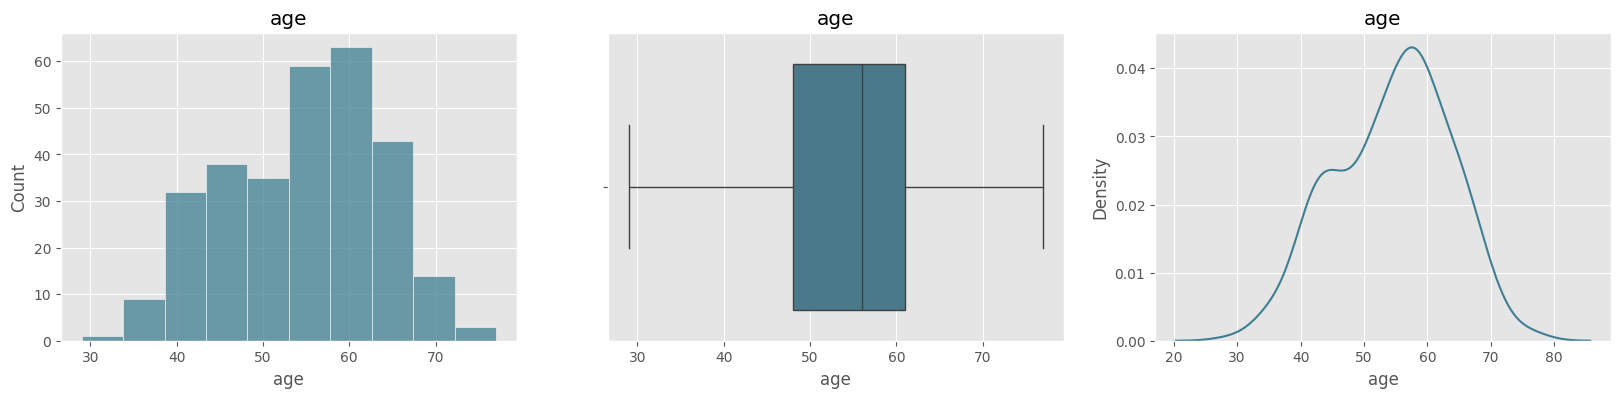

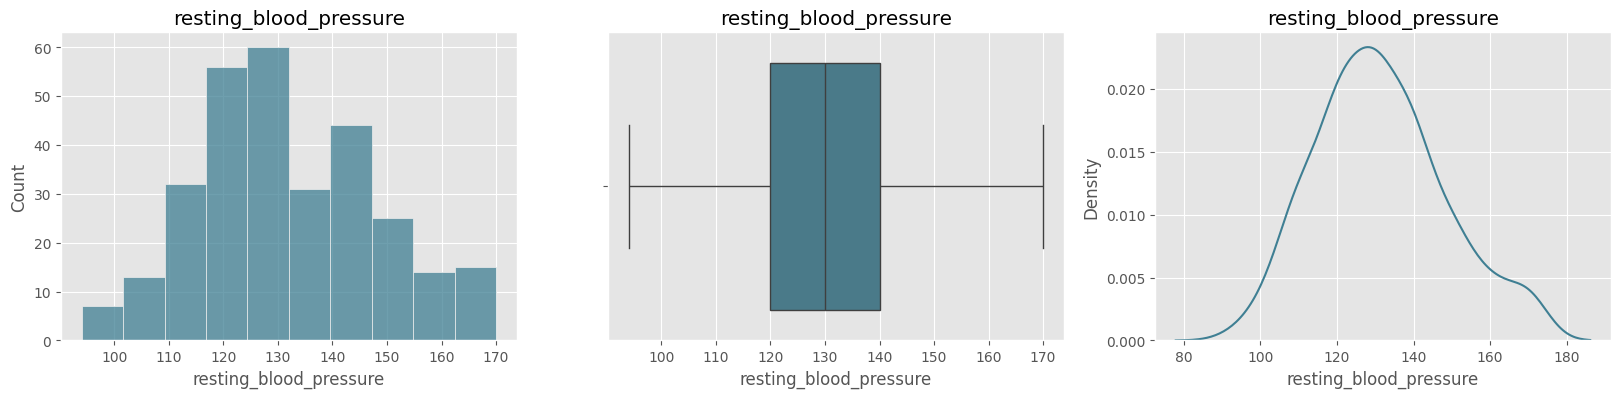

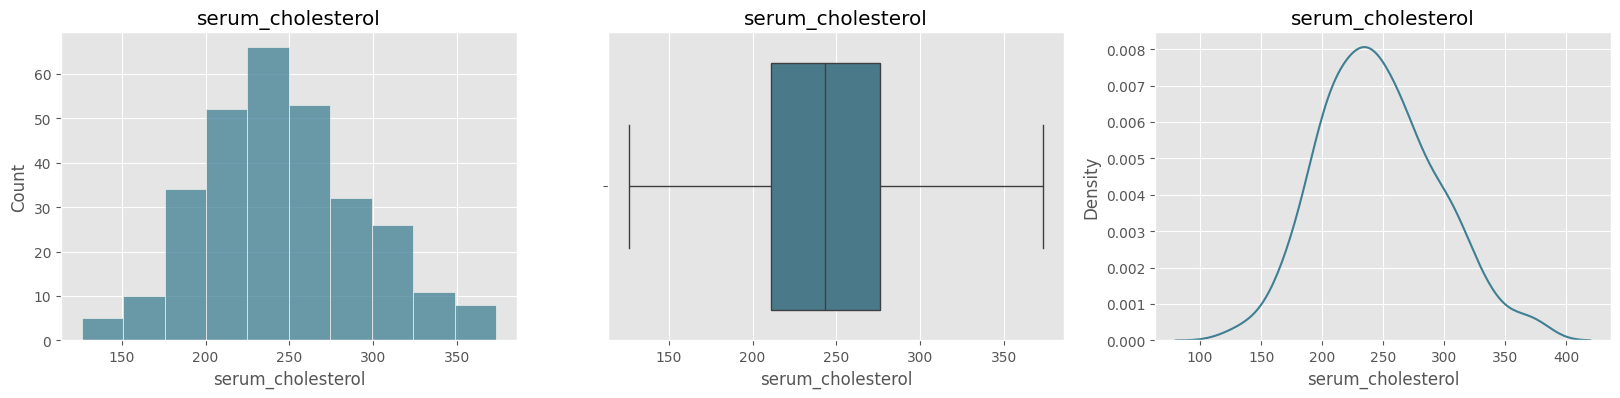

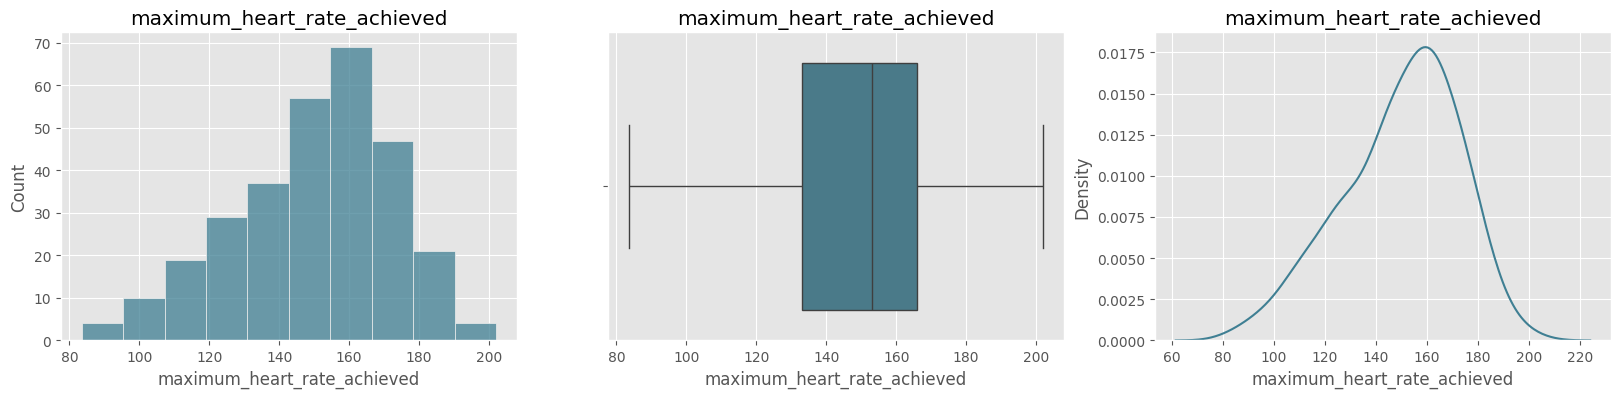

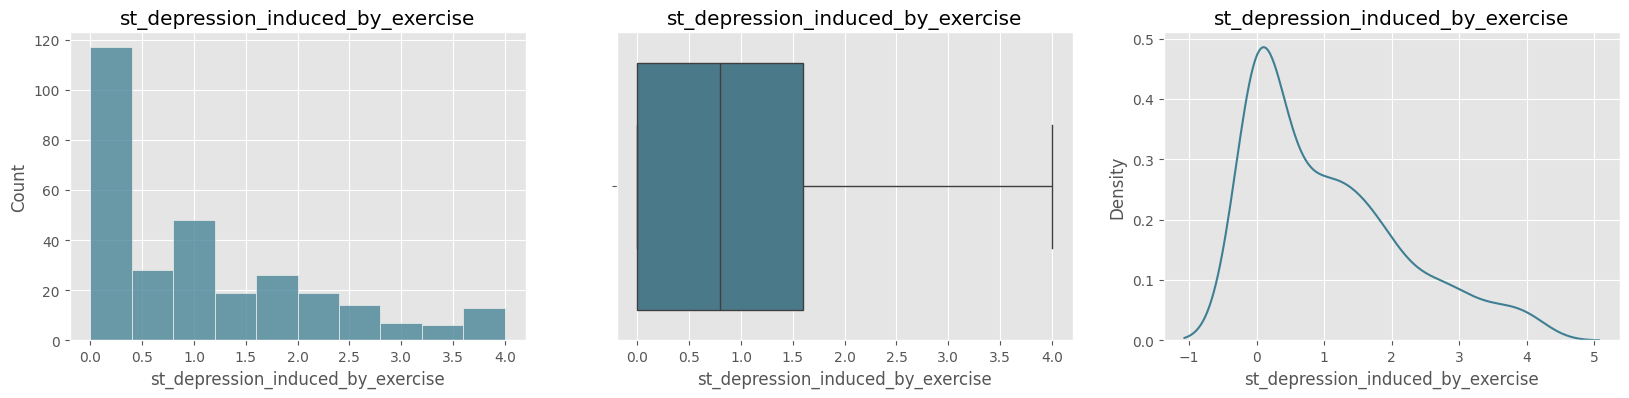

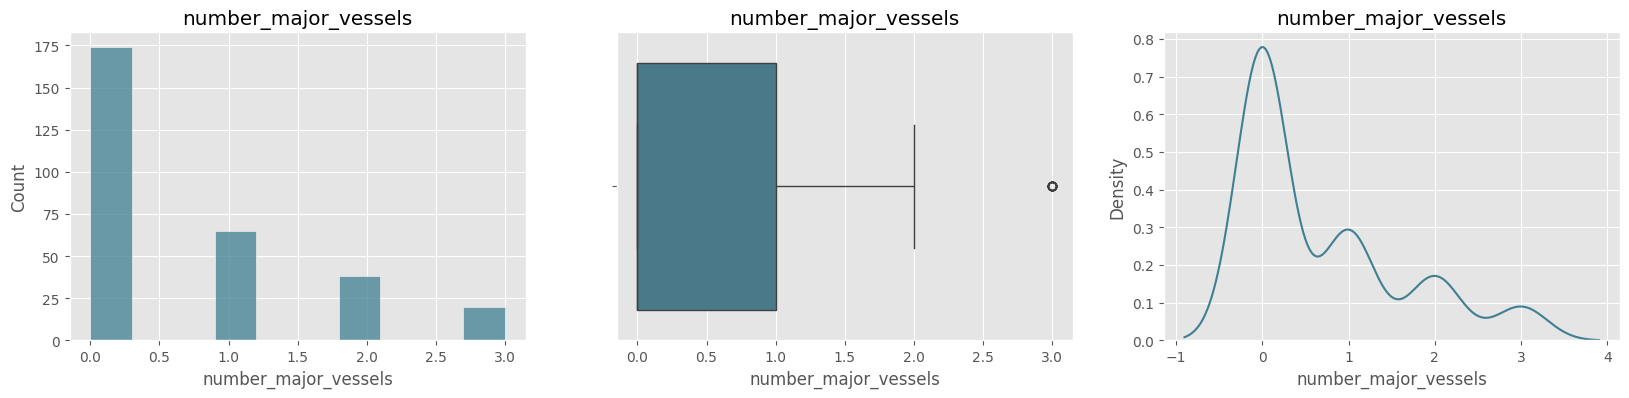

In [105]:
plot_features(df[numeric_features])

- **Aykırı değer işlemleri neticesinde dağılımlarda azda olsa düzelmeler gözlemlenmiştir. Özellikle serum cholestrol özelliği normale yaklaşmıştır.**
- **Sağa ve sola çarpık verilerin olduğu bu datasette model performanslarını artırmak amacı ile modelleme aşamasında scaling(ölçekleme) yapılacaktır.**

**Sayısal kategorik değişkenlerin doğrulaması**
- Kategorilerde farklı bir değer yoktur. Doğrulama yapılmıştır.

In [106]:
numeric_categorical_features = [
    "sex",
    "chest_pain_type",
    "fasting_blood_sugar",
    "resting_ecg_results",
    "exercise_induced_angina",
    "thal",
    "slope_peak_exercise_st_segment",
    "presence_of_heart_disease"
]

In [107]:
for feature in numeric_categorical_features:
    print(df[[feature]].value_counts())

sex
1      201
0       96
Name: count, dtype: int64
chest_pain_type
4                  142
3                   83
2                   49
1                   23
Name: count, dtype: int64
fasting_blood_sugar
0                      254
1                       43
Name: count, dtype: int64
resting_ecg_results
0                      147
2                      146
1                        4
Name: count, dtype: int64
exercise_induced_angina
0                          200
1                           97
Name: count, dtype: int64
thal
3.0     164
7.0     115
6.0      18
Name: count, dtype: int64
slope_peak_exercise_st_segment
1                                 139
2                                 137
3                                  21
Name: count, dtype: int64
presence_of_heart_disease
0                            214
1                             83
Name: count, dtype: int64


# Feature Engineering

**Kategorik değişkenlerin encode edilmesi**

- Kategorik değişkenler tek tek incelenip uygun encoding metodları uygulanmıştır.

**Sex**

- Erken ve kadın değerleri veri setinde  0 ve 1 olarak encode edilmiş haldedir. İlave bir işlem yapılmamıştır

In [108]:
describe_categorical_feature(df, "sex")

Veri tipi: int64


,sex,count
0,1,201
1,0,96


**Chest pain type**

- Göğus ağrısı tiplerini ifade eder. Açıklamalardan görüldüğü üzere göğüs ağrısı tipleri arasında büyüklük küçüklük ilişkisi yoktur. Bunlar nominal kategorik değişkenlerdir. Bu nedenle one hot encoding yönteminin uygulanması daha uygun olacaktır.
  
- İlk önce rakamların hangi değerlere karşılık geldiği maplenip sonra one hot encoing yapılmıştır.

- **1: Typical angina (Tipik anjina)**: 
    - Genellikle fiziksel aktivite veya stres sırasında ortaya çıkan ve dinlenme veya nitrogliserin ile hafifleyen göğüs ağrısı.
    - Kalp ile ilgili olduğu düşünülür.
- **2: Atypical angina (Atipik anjina)**: 
    - Tipik anjinaya benzer ancak semptomlar ve tetikleyiciler açısından farklılık gösterir.
    - Kalp ile ilgili olabilir veya olmayabilir.
- **3: Non-anginal pain (Non-anjiinal ağrı)**: 
    - Göğüs ağrısı, ancak tipik anjinaya benzemeyen ve genellikle kalp ile ilgili olmayan ağrılar.
    - Örneğin, kas veya iskelet sistemi kaynaklı olabilir.
- **4: Asymptomatic (Asemptomatik)**: 
    - Göğüs ağrısı olmadan kalp hastalığı veya benzeri durumlar.

In [109]:
describe_categorical_feature(df, "chest_pain_type")

Veri tipi: int64


,chest_pain_type,count
0,4,142
1,3,83
2,2,49
3,1,23


In [110]:
chest_pain_type_dict = {
    1 :"cp_typical_angina",
    2 :"cp_atypical_angina",
    3 :"cp_non_anginal_pain",
    4: "cp_asymptomatic"
}
df["chest_pain_type"] = df["chest_pain_type"].map(chest_pain_type_dict)
describe_categorical_feature(df, "chest_pain_type")

Veri tipi: object


,chest_pain_type,count
0,cp_asymptomatic,142
1,cp_non_anginal_pain,83
2,cp_atypical_angina,49
3,cp_typical_angina,23


In [111]:
category_one_hot = pd.get_dummies(df["chest_pain_type"]).astype(int)
df.drop("chest_pain_type", axis=1,inplace=True)
df=pd.concat([df,category_one_hot], axis=1)

**fasting_blood_sugar**

- Açlık kan şekeri değeri > 120 mg/dl üzerinde ise 1 değilse 0 olarak kodlanmış haldedir. İlave işleme gerek görülmemiştir.

In [112]:
describe_categorical_feature(df, "fasting_blood_sugar")

Veri tipi: int64


,fasting_blood_sugar,count
0,0,254
1,1,43


**resting_ecg_results**

- Dinlenme EKG sonuçlarını ifade eder. Açıklamalardan görüldüğü üzere arasında büyüklük küçüklük ilişkisi yoktur. Bunlar nominal kategorik değişkenlerdir. Bu nedenle one hot encoding yönteminin uygulanması daha uygun olacaktır.

**0: Normal**:
- Kalp elektrokardiyogramında (EKG) herhangi bir anormallik göstermeyen, normal bir ST-T dalga şekli.

**1: ST-T Dalga Anormalliği**:
- ST-T dalgasında anormallikler bulunur; bu, T dalgası inversiyonu ve/veya ST segmentinde > 0.05 mV yükselme veya çöküşü içerebilir.

**2: Muhtemel veya Kesin Sol Ventrikül Hipertrofisi**:
- Estes kriterlerine göre sol ventrikül hipertrofisini gösteren bir EKG bulgusu.

In [113]:
describe_categorical_feature(df, "resting_ecg_results")

Veri tipi: int64


,resting_ecg_results,count
0,0,147
1,2,146
2,1,4


In [114]:
ecg_results_dict = {
    0: "ecg_normal",
    1: "ecg_st_t_wave_abnormality",
    2: "ecg_left_ventricular_hypertrophy"
}
df["resting_ecg_results"] = df["resting_ecg_results"].map(ecg_results_dict)
describe_categorical_feature(df, "resting_ecg_results")

Veri tipi: object


,resting_ecg_results,count
0,ecg_normal,147
1,ecg_left_ventricular_hypertrophy,146
2,ecg_st_t_wave_abnormality,4


In [115]:
category_one_hot = pd.get_dummies(df["resting_ecg_results"]).astype(int)
df.drop("resting_ecg_results", axis=1,inplace=True)
df=pd.concat([df,category_one_hot], axis=1)

**exercise_induced_angina**

- Egzersiz sonucu ortaya çıkan anjina (göğüs ağrısı). Bu, fiziksel aktivite veya stres sırasında göğüs ağrısının meydana gelmesini ifade eder. Yine veri setinde egzersiz sonrası ağrı varsa 1 yoksa 0 olarak kodlandığından ilave işlem yapılmamıştır.

In [116]:
describe_categorical_feature(df, "exercise_induced_angina")

Veri tipi: int64


,exercise_induced_angina,count
0,0,200
1,1,97


**thal**

**thal:** Thallium stres testi sonuçlarını ifade eder. Bu test, kalp kasının kan akışını ve oksijenlenmesini değerlendirmek için kullanılır. Test, kalp kasının bazı bölgelerinde kan akışının yeterliliğini incelemek amacıyla yapılır. Aralarında büyüklük küçüklük ilişkisi yoktur. Bunlar nominal kategorik değişkenlerdir. Bu nedenle one hot encoding yönteminin uygulanması daha uygun olacaktır.

**Thallium Stresi Testi Sonuçları:**

**3: Normal**:
- Kalp kasının kan akışında herhangi bir anormallik göstermeyen, normal bir durum.

**6: Sabit Defekt**:
- Kalp kasında egzersiz veya ilaç tedavisi ile iyileşmeyen kalıcı bir defekt veya hasar. Bu, kalpteki belirli bölgelerde kalıcı bir bozukluğu ifade eder.

**7: Geri Dönüşlü Defekt**:
- Kalp kasında egzersiz veya ilaç tedavisi sonrası iyileşebilen geçici bir defekt veya hasar. Bu, tedavi veya egzersiz sonrası düzelebilen bir bozukluğu ifade eder.

In [117]:
describe_categorical_feature(df, "thal")

Veri tipi: float64


,thal,count
0,3.0,164
1,7.0,115
2,6.0,18


In [118]:
thal_dict = {
    3: "thal_normal",
    6: "thal_fixed_defect",
    7: "thal_reversable_defect"
}
df["thal"] = df["thal"].map(thal_dict)
describe_categorical_feature(df, "thal")

Veri tipi: object


,thal,count
0,thal_normal,164
1,thal_reversable_defect,115
2,thal_fixed_defect,18


In [119]:
category_one_hot = pd.get_dummies(df["thal"]).astype(int)
df.drop("thal", axis=1,inplace=True)
df=pd.concat([df,category_one_hot], axis=1)

**slope_peak_exercise_st_segment**

**slope:** Egzersiz sırasında ST segmentinin eğimi. Bu, bir elektrokardiyogram (EKG) üzerinde egzersiz sırasında ST segmentindeki değişiklikleri ölçer. ST segmentinin fiziksel aktiviteye nasıl yanıt verdiğini değerlendirmeye yardımcı olur. Yine one hot encoding ile encode etmek uygun olacaktır.


**Slope of Peak Exercise ST Segment Values:**

**1: Upsloping**:
- ST segmentin egzersiz sırasında yukarı doğru eğimli olduğu durum. Genellikle iyi bir kalp kası kan akışını ve uygun kalp fonksiyonunu gösterir.

**2: Flat**:
- ST segmentin egzersiz sırasında düz olduğu durum. Bu, kalp kasında yeterli kan akışı olup olmadığını anlamak için dikkatli değerlendirilmesi gereken bir durumdur.

**3: Downsloping**:
- ST segmentin egzersiz sırasında aşağıya doğru eğimli olduğu durum. Genellikle kalp kasında potansiyel bir sorun veya oksijen yetersizliği işareti olabilir.

In [120]:
describe_categorical_feature(df, "slope_peak_exercise_st_segment")

Veri tipi: int64


,slope_peak_exercise_st_segment,count
0,1,139
1,2,137
2,3,21


In [121]:
slope_dict = {
    1: "slope_upsloping",
    2: "slope_flat",
    3: "slope_downsloping"
}
df["slope_peak_exercise_st_segment"] = df["slope_peak_exercise_st_segment"].map(slope_dict)
describe_categorical_feature(df, "slope_peak_exercise_st_segment")

Veri tipi: object


,slope_peak_exercise_st_segment,count
0,slope_upsloping,139
1,slope_flat,137
2,slope_downsloping,21


In [122]:
category_one_hot = pd.get_dummies(df["slope_peak_exercise_st_segment"]).astype(int)
df.drop("slope_peak_exercise_st_segment", axis=1,inplace=True)
df=pd.concat([df,category_one_hot], axis=1)

**presence_of_heart_disease (Target)**

**`presence_of_heart_disease`** değişkeni, kalp hastalığının varlığını belirlemek için kullanılan bir hedef değişkendir. 

**`presence_of_heart_disease` (Hedef)**:

- **0**: Kalp hastalığı yok.
- **1**: Kalp hastalığı var.

Bu değişken, genellikle tıbbi verilerde kalp hastalığını tahmin etmek için kullanılan bir hedef değişken olup, modelin sonuçlarını değerlendirmek amacıyla kullanılır.

In [123]:
describe_categorical_feature(df, "presence_of_heart_disease")

Veri tipi: int64


,presence_of_heart_disease,count
0,0,214
1,1,83


**Encoding işlemleri tamamlanmıştır.**

In [124]:
df.head()

,age,sex,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,number_major_vessels,presence_of_heart_disease,cp_asymptomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,ecg_left_ventricular_hypertrophy,ecg_normal,ecg_st_t_wave_abnormality,thal_fixed_defect,thal_normal,thal_reversable_defect,slope_downsloping,slope_flat,slope_upsloping
0,63,1,145,233.0,1,150.0,0,2.3,0.0,0,0,0,0,1,1,0,0,1,0,0,1,0,0
1,67,1,160,286.0,0,108.0,1,1.5,3.0,1,1,0,0,0,1,0,0,0,1,0,0,1,0
2,67,1,120,229.0,0,129.0,1,2.6,2.0,0,1,0,0,0,1,0,0,0,0,1,0,1,0
3,37,1,130,250.0,0,187.0,0,3.5,0.0,0,0,0,1,0,0,1,0,0,1,0,1,0,0
4,41,0,130,204.0,0,172.0,0,1.4,0.0,0,0,1,0,0,1,0,0,0,1,0,0,0,1


**Faeture Extraction (Özellik Çıkarımı)**

- Bu kısımda veri setindeki değişkenler kullanılarak. Modelin daha performanslı çaçışmasını sağlayacak yeni değişkenler türetilecektir.

daha ssonra burayı yap, özellik çıkarmak için keşifsel veri analizi aşamaları olabilir

# Feature Selection

**Korelasyon Analizi**

- Hedef değişkenimiz presence_of_heart_disease dir. Bu değişken ile diğer sayısal değişkenlerin arasında bir korelasyon olup olmadığı analiz edilmiştir. 

**Pairplot**

- Bütün özelliklerin görselleştirilmesi uzun sürdüğü ve okunabilir olmadığı için sadece sayısal değişkenler görselleştirilmiştir.
- age ile maximum_heart_rate_achieved arasında güçlü negatif korelasyon göze çarpmaktadır, 
- yine age ile serum kolestrol arasında güçlü olabilecek bir ilişki gözlemlenmektedir.


<Figure size 2500x1500 with 0 Axes>

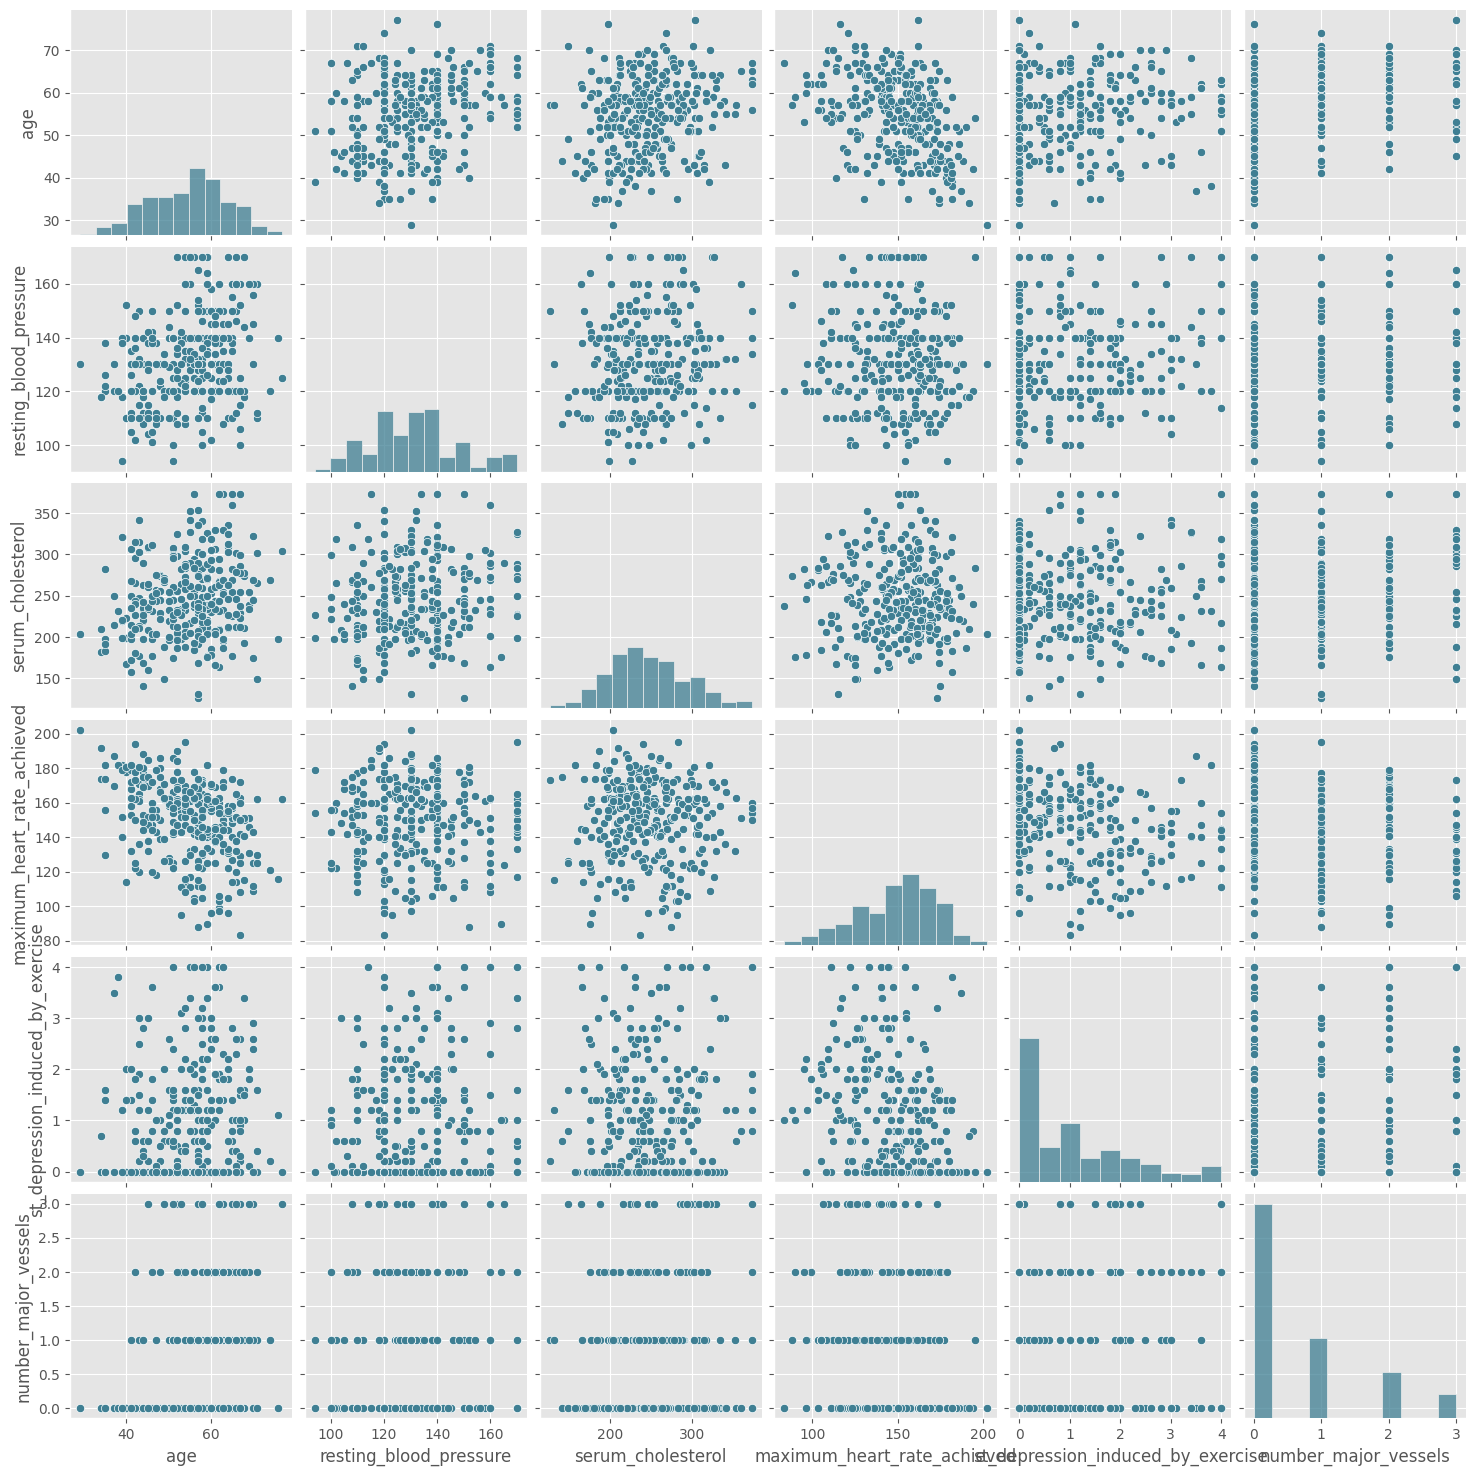

In [125]:
plt.figure(figsize=(25, 15))
sns.pairplot(data=df[numeric_features])
plt.show()

**Heatmap**

In [129]:
len(df.columns)

23

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297 entries, 0 to 301
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   age                                297 non-null    int64  
 1   sex                                297 non-null    int64  
 2   resting_blood_pressure             297 non-null    int64  
 3   serum_cholesterol                  297 non-null    float64
 4   fasting_blood_sugar                297 non-null    int64  
 5   maximum_heart_rate_achieved        297 non-null    float64
 6   exercise_induced_angina            297 non-null    int64  
 7   st_depression_induced_by_exercise  297 non-null    float64
 8   number_major_vessels               297 non-null    float64
 9   presence_of_heart_disease          297 non-null    int64  
 10  cp_asymptomatic                    297 non-null    int32  
 11  cp_atypical_angina                 297 non-null    int32  
 12 

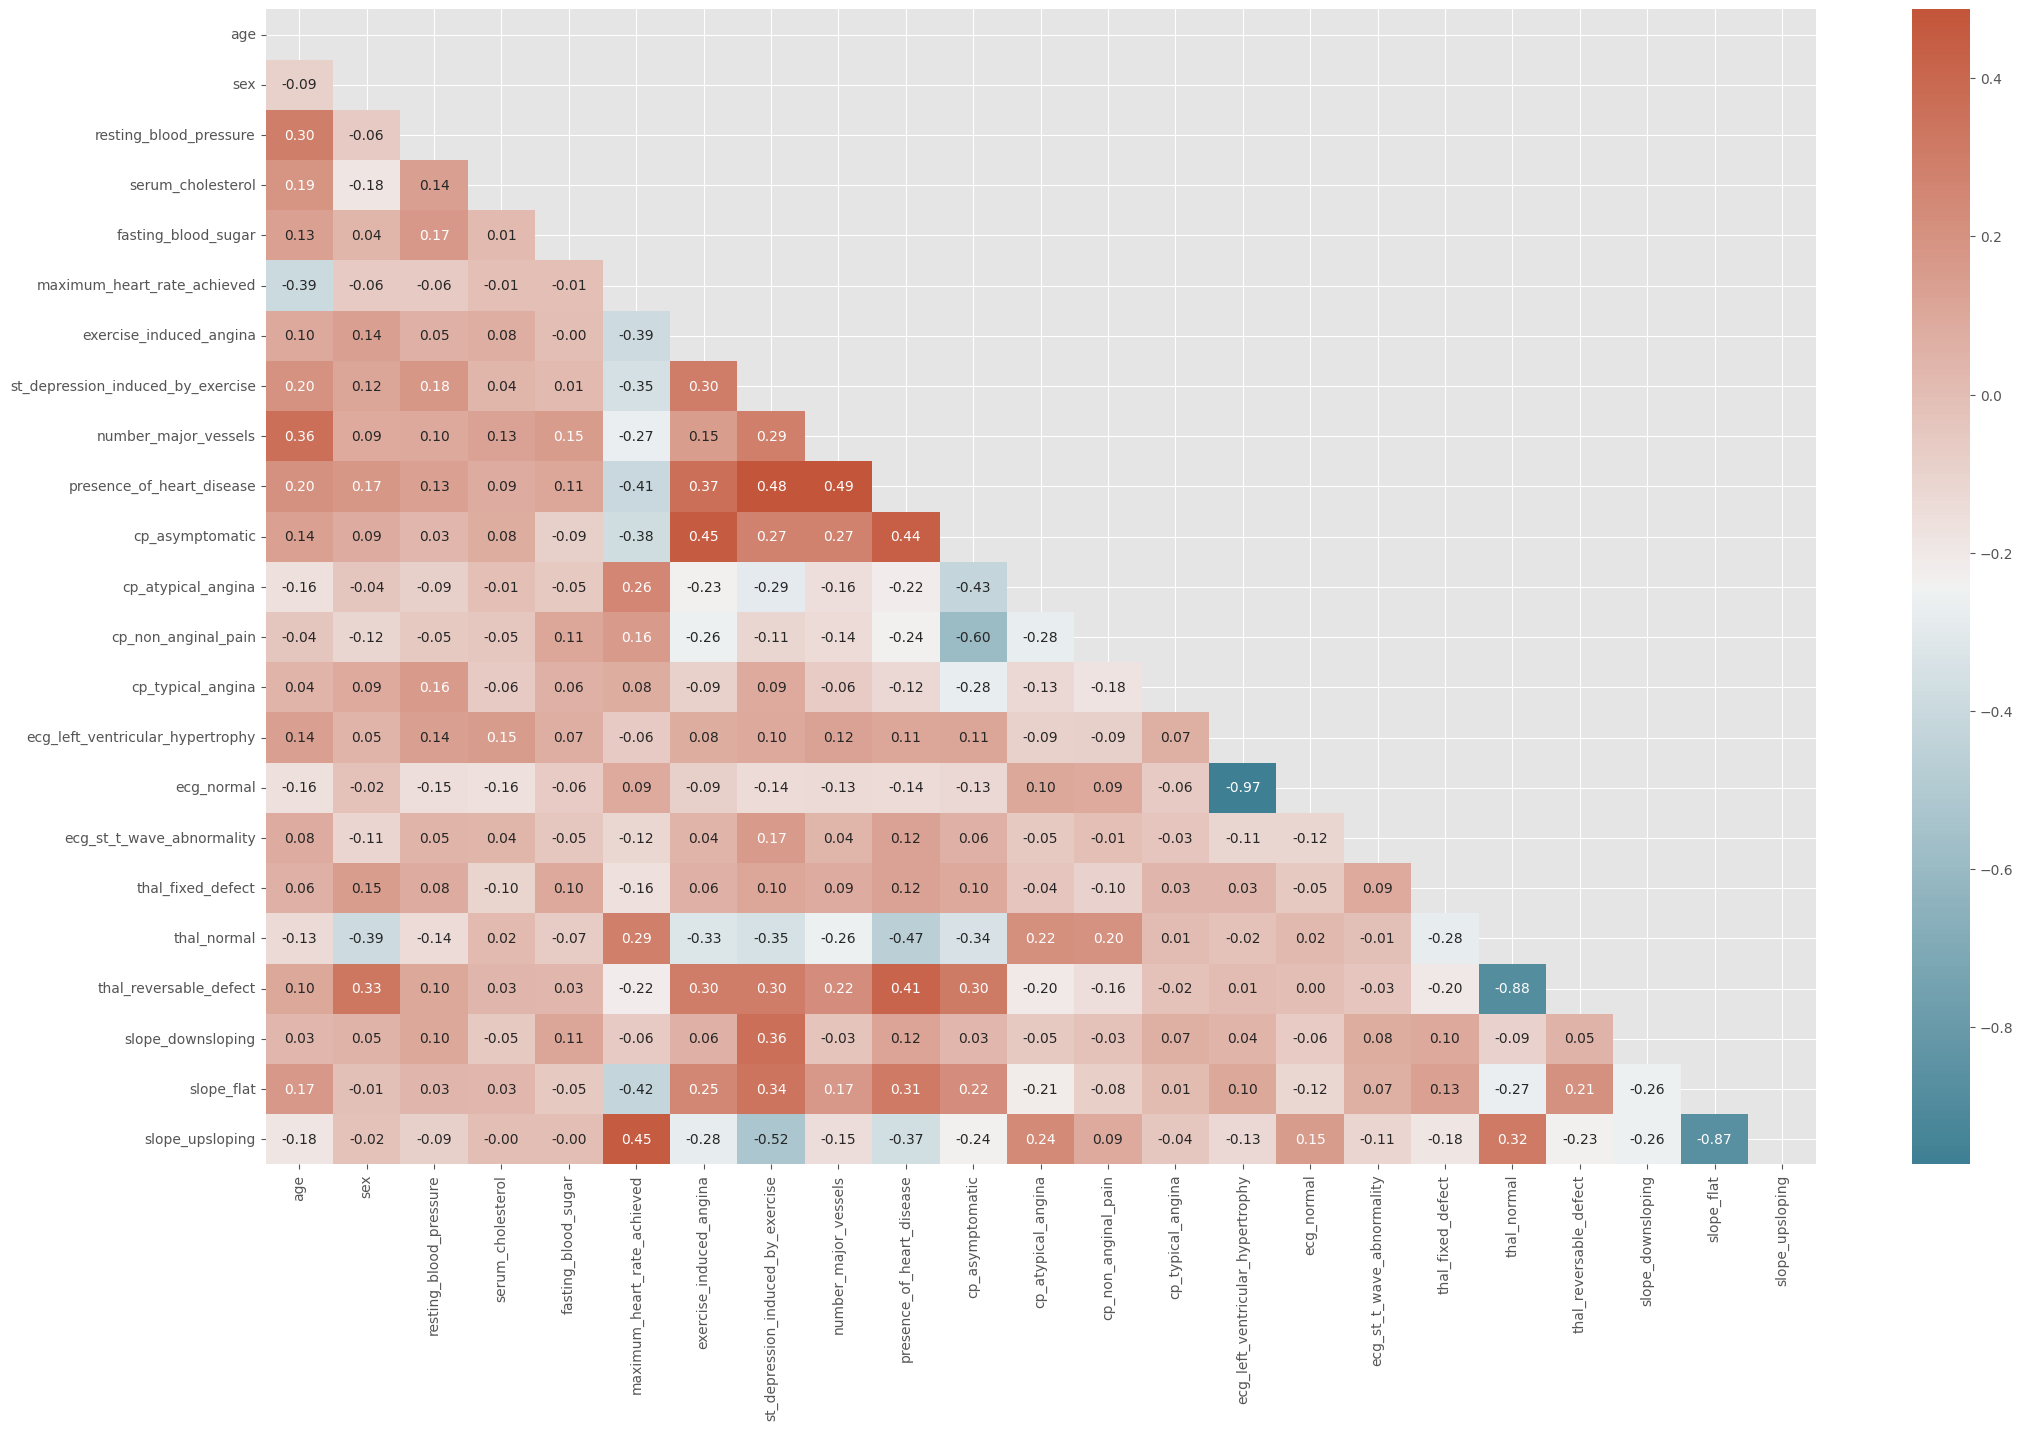

In [131]:
plt.figure(figsize=(25, 15))
num_variables = df.select_dtypes(include=["float64","int64","int32"])
corr_df = num_variables.corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(tri_df,annot=True,fmt=".2f",cmap = cmap)
plt.show()

**Heatmap incelemesi ve birbiri arasında korelasyonlu değişkenlerin tespiti**

- Burada görselin daha anlaşılır olması için np.triu ile ones_like birlikte kullanılarak bool değerler oluşurup üst üçgenin gösterilmemesini sağlanmıştır.
Aşağıda heatmapi incelediğimizde korelasyonlar renkler ile açıkça görülmektedir. Kırmızılar pozitif maviler negatif korelasyonları temsil etmektedir.

Değişkenler arasında %70 den fazla korelasyonu olanlar multicollinearity problemi oluşmaması için korelasyonlu olanları biri kullanılmayacaktır.
Yüksek korelasyonlu değişkenler aynı bilgiyi ifade ettiklerinden aralarındaki küçük farklar makine öğrenimi modelini yanıltabilir. Bu nedenle bu değişkenlerin çıkarılması model performansını artırabilir.

Bu değişkenler:
- ecg_normal - ecg_left_ventricular_hypertropy: -0.97 lik çok yüksek negatif korelasyon vardır. ecg_left_ventricular_hypertrophy özelliği çıkarılmıştır.
- thal_mormal - thal_reversible_defect: -0.88 lik çok yüksek negatif korelasyon vardır. thal_reversable_defect özelliği çıkarılmıştır.
- slope_flat - slope_upsloping: -0.87 lik çok yüksek negatif korelasyon vardır. slope_upsloping özelliği çıkarılmıştır.

In [132]:
featueres_high_corr = ["ecg_left_ventricular_hypertrophy","thal_reversable_defect","slope_upsloping"]
df.drop(featueres_high_corr, axis= 1, inplace=True)

**Hedef özellik (presence_of_heart_disease) ile diğer özelliklerin arasındaki korelasyonların tespiti**
- Burada target değişken presence_of_heart_disease ile sayısal değişkenlerin korelasyonuna bakılmıştır. Eşik değer 0.05 korelasyonlu olarak belirlenmiş ve görselleştirilmiştir. 
- İlk önce birbiri ile korelasyonlu değişkenler kaldırılıp tam olarak hedef değişken ile korelasyonlu değişkenlerin kaç adet olduğu tespit edilmiştir. 
- Target değişken ile bağımsız değişkenler arasında 0.05 korelasyondan yüksek 13 özellik tespit edilmiştir.

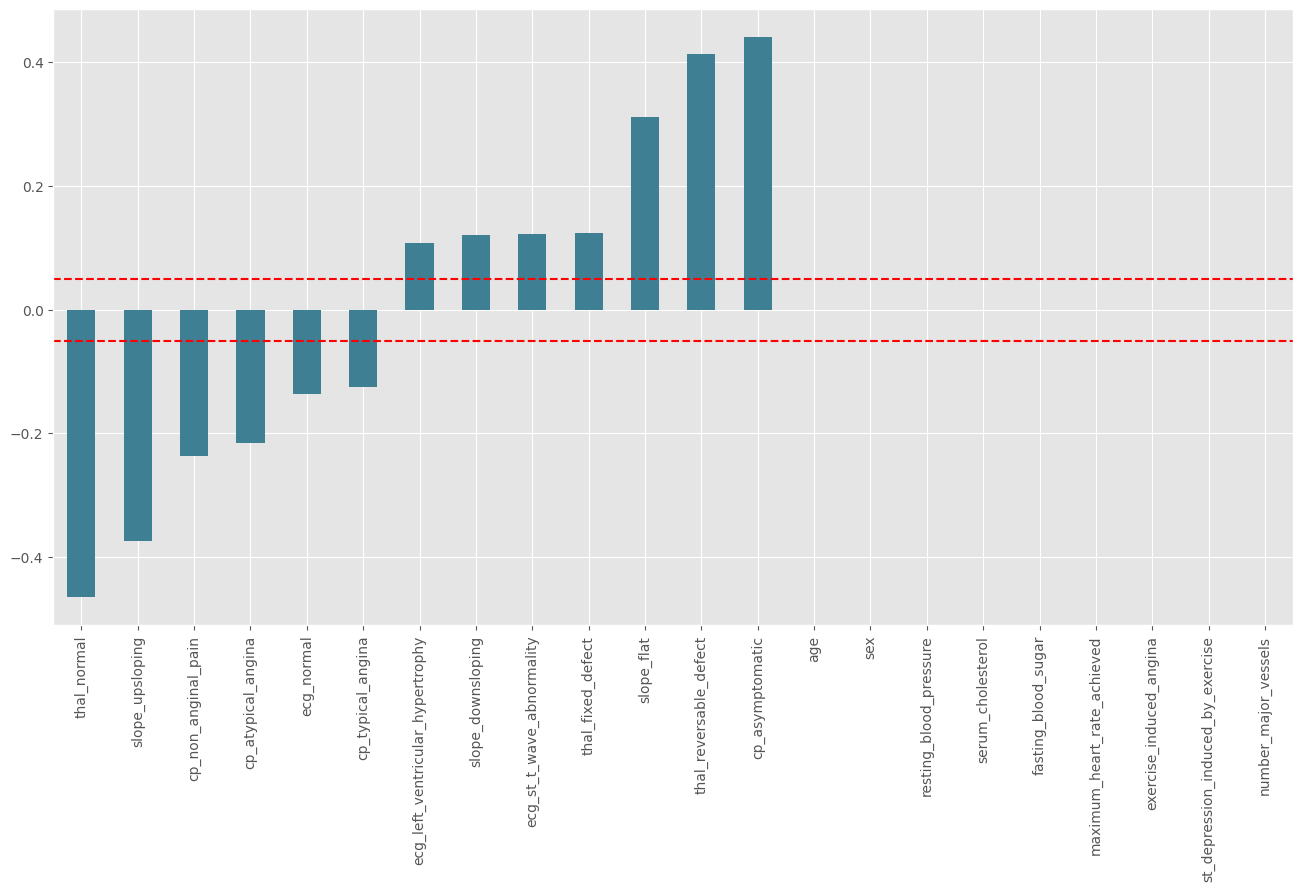

In [133]:
plt.figure(figsize=(16, 8))
tri_df["presence_of_heart_disease"].drop("presence_of_heart_disease").sort_values().plot(kind="bar")
plt.axhline(0.05, color ="red",linestyle ='--')
plt.axhline(-0.05, color='red',linestyle='--')
plt.show()

In [135]:
cor_target = abs(tri_df["presence_of_heart_disease"])
cor_target.drop("presence_of_heart_disease",inplace=True,axis=0)
correlated_features  = cor_target[cor_target >=0.05]
print("Toplam özellik sayısı:",len(df.select_dtypes(include=["float64","int64","int32"]).columns))
print("Korelasyonlu özellik sayısı:",len(correlated_features))

Toplam özellik sayısı: 20
Korelasyonlu özellik sayısı: 13


# Model Oluşturma ve Değerlendirme

### Bu bölüm altında projede istenen scaling, normalization, sampling işlemleri ilgili yerlerde yapılacaktır.

**Kullanılacak Modellerin Seçimi**

- presence_of_heart_disease yani kişinin kalp hastası olup olmadığının tahmin edilmesi, makine öğreniminde binary sınıflandırma problemidir. 
  
- Occam's razor yani basitmodelden karmaşık modele gitme prensibinden dolayı ilk olarak Lojistik Regresyon modeli kullanılmıştır. Veri setinde güçlü doğrusal korelasyonlar bulunduğundan iyi performans gösterebilir. Logistic regresyonu ayrıca tek neronlu basit bir sinir ağı olarakda düşünebiliriz. Loss(kayıp) fonksiyonu olarak katsayıların güncellenmesinde binary crossentropy fonksiyonu kullanılır. 
  
- İkinci model olarak ağaç tabanlı bir model kullanılması tercih edilmiştir. Ağaç tabanlı modellerden de boosting(örn: xgboost), bagging(bootstrap aggregation) modelleri(örn: random forest) arasında seçim yapılması gerektiğinde RandonForestClassifier modeli tercih edilmiştir. Bunun nedenide boosting algoritmaları özelliklede xgboost yüksek boyutlu veri setlerinde daha iyi performans gösterirler. Projemizdeki veri seti çok küçük olduğundan overfitting(aşırı uyum) olma ihtimali dahada artabileceğinden karşılaştırma modeli olarak Random Forests Classifier'ı seçilmiştir. 
  
- Ağaç tabanlı model seçilmesinin bir diğer nedenide sınıf dengesizliği sorununu ele alabilir ve dengesiz veri setlerinde iyi performans gösterebilir. Ayrıca, tek bir ağaç modeli yerine, birçok bağımsız zayıf ağacın ortak kararıyla sonuç üreten ve kalabalık bilgeliği prensibine dayanan sıklıkla kullanılan bir model olan Random Forest Classifier kullanılmıştır. Ayrıca ağaç tabanlı modeller ölçeklemeye karşıda dirençlidir. Veri seti ölçeklenmedende kullanılabilir.
  
-  Her iki modelin de sınıf dengesizliklerini class_weights parametresi ile ele alması ve düşük yoğunluklu sınıflara önem vererek ele almaktadır. 
  
---

**Değerlendirme Metriklerinin Seçimi**

İlk metrik seçimi için önemli olabilecek 2 metrik için değerlendirme yapılmıştır. 

**Precision (Kesinlik):**

- **Tanım:** Doğru pozitif tahminlerin, tüm pozitif tahminlere (doğru pozitif + yanlış pozitif) oranıdır.
- **Formül:**
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
- **Anlamı:** Modelin pozitif sınıfa (kalp hastalığı) ait olarak sınıflandırdığı hastaların ne kadarının gerçekten kalp hastalığına sahip olduğunu gösterir.
- Eğer yanlış pozitifler (kalp hastası olarak yanlış sınıflandırılan sağlıklı bireyler) ciddi sonuçlara yol açıyorsa, precision daha önemli olabilir. Örneğin, hastalara gereksiz tedavi veya endişe vermemek için, yanlış pozitiflerin sayısını azaltmak önemlidir.

**Recall (Duyarlılık):**

- **Tanım:** Gerçek pozitiflerin (kalp hastalığı olanlar) tüm pozitif durumlara (gerçek pozitif + yanlış negatif) oranıdır.
- **Formül:**
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$
- **Anlamı:** Gerçek kalp hastalığı olan hastaların ne kadarının doğru bir şekilde tespit edildiğini gösterir.
- Eğer yanlış negatifler (kalp hastalığı olan bireylerin sağlıklı olarak sınıflandırılması) daha büyük bir risk taşıyorsa, recall daha önemli olabilir. Örneğin, kalp hastalığı olan bir bireyin hastalığının tespit edilmemesi, hayati tehlikelere yol açabilir.


- Kalp hastalığı olan birinin sağlıklı olarak sınıflandırılmaması gerektiği düşünüldüğünden ilk değerlendirme metriği olarak **RECALL** seçilmiştir.


İkinci metrik olarak **ROC AUC score** seçilmiştir. ROC AUC score, modelin tüm sınıfları (hem pozitif hem de negatif) doğru şekilde ayırt etme yeteneğini değerlendirir. Bu, yanlış pozitifler ve yanlış negatifler (duyarlılık ve özgüllük -(sensitivity and specificity)) arasında bir denge kurmaya odaklanır.

---

**Model Değerlendirme Fonksiyonunu Tanımlama**

Tüm model eğitim ve değerlendirme sürecini kolay ve hatasız hale getirmek için bir fonksiyon içinde gerçekleştirilmiştir. Bu fonksiyon modeli, bölünmüş verileri, cross-validation fonksiyonunu ve score fonksiyonunu parametre olarak alır ve eğitimli modeli, eğitim ve doğrulama puanlarını içeren dataframe'i, nihai test puanını ve test seti üzerindeki tahminleri döner. Eğer plot parametresi True olarak belirtilirse, eğitim ve doğrulama sonuçlarını çizer. Eğitim verileri üzerinde cross-validation uygulamak, model değerlendirme aşamasında sıkça tercih edilen bir yöntemdir. Bu şekilde, modelin eğitim, doğrulama ve test seti üzerindeki sonuçlarını karşılaştırarak aşırı uyum (overfitting) ve yetersiz uyum (underfitting) durumlarını daha kolay gözlemlenebilir ve hiperparametreler bu sonuçlara göre ayarlayabilir. Ayrıca, problem sınıflandırma ise fonksiyon, confusion matrix'i de yazdırır. sklearn'deki karmaşıklık matrisi, modelin doğru negatif, yanlış pozitif tahminlerini birinci satırda ve yanlış negatif, doğru pozitif tahminlerini ikinci satırda gösterir.

![Local Image](./confusion.jpg)

In [136]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test,score_func, cv_type, plot=True):
 
    # score listelerinin tanımanması
    train_scores = []
    validation_scores = []
    score_per_fold = []
    fold = 1

    # overfitting underfitting tespiti için cross validation aşaması
    for train_index, test_index in cv_type.split(X_train,y_train):
        X_train_cv, X_validation_cv = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_cv, y_validation_cv = y_train.iloc[train_index], y_train.iloc[test_index]

        # cross validation eğitim seti model fit 
        model.fit(X_train_cv, y_train_cv)
        y_pred_train = model.predict(X_train_cv)
        y_pred_validation = model.predict(X_validation_cv)
        
        # eğitim scorlarının hesaplanması
        train_score = score_func(y_train_cv, y_pred_train)
        
        # validation scorelarıın hesaplanması
        validation_score = score_func(y_validation_cv, y_pred_validation)

        # scoreların listelere eklenmesi
        train_scores.append(train_score)
        validation_scores.append(validation_score)

        # socreların her fold için yazdırılması
        print(f'Fold {fold} eğitim_{score_func.__name__}: {train_score:.2f}')
        print(f'Fold {fold} validasyon_{score_func.__name__}: {validation_score:.2f}')

        fold += 1
        # fold sayısının listeye eklenmesi
        score_per_fold.append(fold)

    print("Cross validation aşaması tamamlandı! Model eğitimine başlandı...")

    # Cross validasyon aşaması tamamlandıktan sonra modelin tüm veri seti üzerinde tekrar eğitilmesi
    model.fit(X_train, y_train)
    print("*******************************************")
    print("Model eğitimi tamamlandı!")
    print("*******************************************")

    # test seti üzerinde tahmin yapılması ve eğer skor fonksiyonunun adı `roc_auc_score` ise, 1 sınıfına ait tahmin edilen olasılıkların alınması.
    if score_func.__name__ == "roc_auc_score":
        y_pred_test = model.predict_proba(X_test)[:,1]
    else:
        y_pred_test = model.predict(X_test)
    
    # En son test seti üzerinde score hesaplanması
    final_test_score = score_func(y_test, y_pred_test)

    # scoreların sözlüğe kaydedilmesi
    scores_dict = {
    "fold": range(1, len(score_per_fold) + 1),
    f"eğitim_{score_func.__name__}": train_scores,
    f"validasyon_{score_func.__name__}": validation_scores
    }
    
    # plot için df oluşturulması
    scores_df = pd.DataFrame(scores_dict)
    
    # validasyon scorunun eğitim scoruna göre farkının % değeri.
    percentage_difference_train_valid = ((np.mean(validation_scores) - np.mean(train_scores)) / np.mean(train_scores)) * 100

    # final scoreun eğitim scoruna göre farkının % değeri.
    percentage_difference_train_test = ((final_test_score - np.mean(train_scores)) / np.mean(train_scores)) * 100

    print(f"Ortalama eğitim_{score_func.__name__} sonuç: {np.mean(train_scores):.2f}")
    print(f'Ortalama validasyon_{score_func.__name__} sonuç: {np.mean(validation_scores):.2f}')
    print(f'Son test_{score_func.__name__} sonuç: {final_test_score:.2f}')
    print(f'Validasyon scorunun eğitim scoruna göre farkının % değeri:%{percentage_difference_train_valid:.2f}')
    print(f'Final scoreun eğitim scoruna göre farkının % değeri:%{percentage_difference_train_test:.2f}')
    # it prints confusion matrix if the problem is classification
    if score_func.__name__ in ["precision_score","recall_score","f1_score"]:
        cf_matrix = confusion_matrix(y_test, y_pred_test)
        print(f"Son test seti için oluşturulan confusion matrix:\n {cf_matrix}")

    print("*******************************************")

    if plot:
        sns.lineplot(data=scores_df, x="fold", y=f"eğitim_{score_func.__name__}", marker="o", label=f"eğitim_{score_func.__name__}")
        sns.lineplot(data=scores_df, x="fold", y=f"validasyon_{score_func.__name__}", marker="v", label=f"validasyon_{score_func.__name__}")
        plt.xlabel("Fold")
        plt.ylabel(f"{score_func.__name__}")
        plt.title(f"Her folddaki {score_func.__name__}")
        plt.legend()
        plt.show()

    return  model, final_test_score, scores_df, y_pred_test

**ROC Eğrisi Fonksiyonunu Tanımlama**

ROC eğrisi, bir ikili sınıflandırma modelinin performansını farklı eşik değerlerinde grafiksel olarak gösterir. Bu eğri, gerçek pozitif oranını (TPR) yanlış pozitif oranına (FPR) karşı çizer. TPR, modelin gerçek pozitif vakaları ne kadar doğru tespit ettiğini ölçerken, FPR, modelin negatif vakaları yanlış bir şekilde pozitif olarak sınıflandırma oranını ölçer. ROC eğrisi, sınıflandırıcının karar eşiği değiştikçe TPR ve FPR arasındaki dengeyi görselleştirir. Eğri Altındaki Alan (AUC), eğrinin altındaki alanı temsil eder ve modelin genel performansını ölçmek için kullanılır. Bu nedenle, ROC eğrisi ve AUC, ikili sınıflandırma modellerinin performansını değerlendirmek ve karşılaştırmak için önemli araçlardır.

In [137]:
def plot_roc_curve(y_true, y_pred_prob):

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

    # Compute Area Under Curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color="teal", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], color="lightsteelblue", lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

In [138]:
df.head()

,age,sex,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,maximum_heart_rate_achieved,exercise_induced_angina,st_depression_induced_by_exercise,number_major_vessels,presence_of_heart_disease,cp_asymptomatic,cp_atypical_angina,cp_non_anginal_pain,cp_typical_angina,ecg_normal,ecg_st_t_wave_abnormality,thal_fixed_defect,thal_normal,slope_downsloping,slope_flat
0,63,1,145,233.0,1,150.0,0,2.3,0.0,0,0,0,0,1,0,0,1,0,1,0
1,67,1,160,286.0,0,108.0,1,1.5,3.0,1,1,0,0,0,0,0,0,1,0,1
2,67,1,120,229.0,0,129.0,1,2.6,2.0,0,1,0,0,0,0,0,0,0,0,1
3,37,1,130,250.0,0,187.0,0,3.5,0.0,0,0,0,1,0,1,0,0,1,1,0
4,41,0,130,204.0,0,172.0,0,1.4,0.0,0,0,1,0,0,0,0,0,1,0,0


**Veri setinin eğitim ve test olarak bölünmesi ve SMOTE oversampling uygulanması**

**Veri setinde presence_of_heart_disease hedef değişkeninde sınıf dengesizliği bulunmaktadır.**

- Sınıf dengesizliğini ele almak için 4 yöntem uygulanmıştır.
  
- 1. Bölme işleminde stratify parametresi kullanılmıştır. train_test_split fonksiyonu bölme yaparken bunu dikkate alır.
  
- 2. Kullanılan modellerde class_weight parametresi balanced yapılmıştır.
  
- 3. Sınıf dengesizliğinde sıklıkla kullanılan **SMOTE** oversampling metodu kullanılmıştır.
  
- 4. Cross validation fonksiyonu olarak Stratified Kfold kullanılmıştır.

In [139]:
describe_categorical_feature(df, "presence_of_heart_disease")

Veri tipi: int64


,presence_of_heart_disease,count
0,0,214
1,1,83


# Sampling

**SMOTE (Synthetic Minority Over-sampling Technique)**

SMOTE, dengesiz veri setlerinde azınlık sınıfının örneklerini artırmak için kullanılan bir over-sampling yöntemidir. Bu teknik, mevcut azınlık sınıfı örnekleri arasındaki farkları kullanarak sentetik örnekler oluşturur ve böylece sınıflar arasındaki dengesizliği azaltır.

**Çalışma şekli:**
1. **K En Yakın Komşu**: Her bir azınlık sınıfı örneği için k en yakın komşu belirlenir.
2. **Yeni Örnekler Oluşturma**: Rastgele bir komşu seçilir ve bu komşu ile mevcut örnek arasındaki vektör boyunca yeni bir örnek oluşturulur.
3. **Oversampling**: Bu adımlar tekrarlanarak veri setine yeni sentetik azınlık sınıfı örnekleri eklenir.

**Avantajları:**
- **Dengesiz Verilerin Dengelenmesi**: Azınlık sınıfı örneklerini artırarak veri setindeki sınıf dengesizliğini azaltır.
- **Overfitting'i Azaltma**: Yeni örnekler oluştururken sadece mevcut örnekleri tekrar etmek yerine yeni sentetik örnekler üreterek overfitting riskini azaltır.
  
**SMOTE, eğitim setindeki azınlık sınıfı örneklerini artırarak modelin bu sınıfı daha iyi öğrenmesini sağlar. Ancak, test seti modelin performansını değerlendirmek için kullanılır ve bu set üzerinde herhangi bir müdahale yapılmamalıdır. Test seti, modelin eğitim süreci dışında kalmalı ve gerçek dünya performansını yansıtmalıdır.**

---

**Özellik seçim ve verilerin bölünmesi**
- Verilerin bölünmesinde test size seçimi önemli ayarlamalardan bir tanesidir.
- Test boyutu seçiminde %10, %12, %15, %20 ve %25 değerleri kullanılmış model değerlendirme fonksiyonunda uygulanmıştır. En eğitim, validasyon ve final scorelara göre en uygun test boyutu %12 seçilmiştir(eğitim recall = 0.88, validation recall=0.89, test recall=0.90- scaled).

In [140]:
mlflow.set_tracking_uri("file:///C:/Users/iskorpittt/Desktop/MY_DATA_SCIENCE/PROJECTS/kodlasam_hearth_disease_project/mlruns")

mlflow.set_experiment("heart_disease_classification")

<Experiment: artifact_location='file:///C:/Users/iskorpittt/Desktop/MY_DATA_SCIENCE/PROJECTS/kodlasam_hearth_disease_project/mlruns/367194866272300660', creation_time=1721977320429, experiment_id='367194866272300660', last_update_time=1721977320429, lifecycle_stage='active', name='heart_disease_classification', tags={}>

In [155]:
target = "presence_of_heart_disease"
columns_that_will_not_used = ["presence_of_heart_disease"]
features = [col for col in df.columns if col not in columns_that_will_not_used]
X = df[features]
y= df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, stratify=y, random_state=42)

In [156]:
print(X_train.shape)
print(y_train.shape)
y_train.value_counts(normalize=True) * 100

(261, 19)
(261,)


presence_of_heart_disease
0    72.030651
1    27.969349
Name: proportion, dtype: float64

In [157]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

- SMOTE işlemi sonucunda X_train satır sayısı 261, den 376'ya çıkmış sentetik datalar üretilmiştir.
- SMOTE öncesi %72 0, %28 1 değeri varken, işlem uygulandıktan sonra %50, %50 olacak hale gelmiştir.
- SMOTE işlemi sadece eğitim setine uygulanmıştır.

In [158]:
print(X_train_smote.shape)
print(X_test.shape)
print(y_train_smote.shape)
print(y_test.shape)
y_train_smote.value_counts(normalize=True) * 100

(376, 19)
(36, 19)
(376,)
(36,)


presence_of_heart_disease
0    50.0
1    50.0
Name: proportion, dtype: float64

**Modelleme**

**Lojistik Regresyon Modeli**

Yüksek oranda sağa çarpıtılmış veriler, modelin daha iyi performans göstermesi için ölçeklenmelidir. Bunun için, pipeline içinde `StandardScaler` kullanılmıştır.

Veri sayısı çok büyük olmadığından, hiperparametre ayarlamaları için en doğru sonucu almak amacıyla GridSearchCV yöntemi kullanılmıştır. Bu süreç sonucunda, düzenleme C değeri 0.003 olarak ve ceza değeri l2 (ridge) olarak belirlenmiştir. Hedef değişkenimizde bir sınıf dengesizliği olduğu için, daha az etkili sınıfı daha fazla dikkate almak adına `class_weight="balanced"` seçeneği tercih edilmiştir.

- **C**: Lojistik regresyondaki düzenleme kuvveti parametresidir. Daha küçük değerler daha güçlü düzenlemeyi ifade eder ve model üzerindeki bireysel veri noktalarının etkisini azaltır.
- **Penalty**: Lojistik regresyonda kullanılan düzenleme cezasının türüdür. "l2" Ridge düzenlemesini ifade eder, bu düzenleme katsayıların karelerinin büyüklüğünü cezalandırarak daha küçük katsayı değerlerini teşvik eder.

Sınıf dengesizliğini ele almak için çapraz doğrulama için StratifiedKFold seçilmiştir.

**Logistic regression hyperparameter tuning**

- Hyperparameter tuning için veri sayısı az olduğundan, brute force yöntemi ile bütün kombinasyonları deneyen Gridsearch kullanılmıştır. 
- Verisayısı ve parametre fazla olduğunda, bu yöntem kullanılamaz hale gelebilir. İşlem süreleri çok uzar. Böyle durumlarda Random search yada bayesian algoritmaları kullanılabilir.

In [159]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
scoring = make_scorer(recall_score) 
lr_cv = LogisticRegression()

lr_pipeline_cv = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", lr_cv)
])

params_lr = {
    "classifier__penalty": ["l1", "l2","elasticnet"],
    "classifier__C": [0.0001, 0.001, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.02, 0.03, 0.04, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 10, 100, 200],
    "classifier__class_weight": ["balanced"] 
} 

with mlflow.start_run(run_name="GridSearchCV Logistic Regression"):

    grid_rf = GridSearchCV(estimator=lr_pipeline_cv,param_grid=params_lr,cv=skf,scoring=scoring,verbose=1,n_jobs=1)
    grid_rf.fit(X,y)
    best_hyperparams_lr = grid_rf.best_params_
    best_score_lr = grid_rf.best_score_
    print("Logistic Regression için en iyi hiperparametreler:", best_hyperparams_lr)
    print("Logistic Regression için en iyi score(recall):", best_score_lr)
    
    # Hyperparametreleri ve en iyi skorların mlflow'a kaydedilmesi
    mlflow.log_params(best_hyperparams_lr)
    mlflow.log_metric("lr_best_recall_score", best_score_lr)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
Logistic Regression için en iyi hiperparametreler: {'classifier__C': 0.005, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l2'}
Logistic Regression için en iyi score(recall): 0.8680555555555556


# Scaling

**Verisetinde denenen ölçekleme yöntemleri**

#### MinMaxScaler
**MinMaxScaler**, veriyi belirli bir aralıkta (genellikle 0 ile 1 arasında) ölçekler. Bu ölçekleme, verinin minimum ve maksimum değerleri kullanılarak yapılır.

- **Formül:**
  $$
  z = \frac{x - x_{min}}{x_{max} - x_{min}}
  $$

#### StandardScaler
**StandardScaler**, veriyi ortalama 0 ve standart sapma 1 olacak şekilde ölçekler. Bu, verinin dağılımını merkezler ve ölçekler.

- **Formül:**
  $$
  z = \frac{x - \mu}{\sigma}
  $$

#### RobustScaler
**RobustScaler**, veriyi medyan ve yüzde değer aralıkları kullanarak ölçekler. Bu ölçekleme yöntemi, aykırı değerlere karşı daha dayanıklıdır.

- **Formül:**
  $$
  z = \frac{x - \text{medyan}}{IQR}
  $$


- Sayısal verilerde aykırı değer analizi yapılmış ve aykırı değerler baskılanmıştır. Fakat yinede V sağa ve sola çarpık özellikler bulunmaktadır.Linear modellerde bunlar bozucu etki yapabilir ve model performansını olumsuz etkiler.
- Bu nedenle verileri uygun bir ölçeğe getirmek model performansını artırabilir.
- Aykırı değer işlemleri yaptığımızdan ve çok aşırı çarpıklıklar olmadığından `StandarScaler` yöntemi kullanılabilir. 
- Yinede 3 yöntem denenmiş en uygun olarak `StandarScaler` en iyi scoreları vermiştir.
- Logistic regression modelinde `StandarScaler` uygulandıktan sonra Recall test scoru 0.80 den, 0.90 ' a yükselmiştir. 
  
- **!!!Not: Bu sonuçlar baseline model aşamasında elde edilmiştir. Feature ekledikten sonra sonuçlar değişmiştir.**

---

**Scaling olmadan model eğitim ve değerlendirmesi**

- Ortalama eğitim_recall_score sonuç: 0.77
- Ortalama validasyon_recall_score sonuç: 0.75
- Son test_recall_score sonuç: 0.80
- Validasyon scorunun eğitim scoruna göre farkının % değeri:%-2.74
- Final scoreun eğitim scoruna göre farkının % değeri:%2.48
- Son test seti için oluşturulan confusion matrix:%3.26
 - [[19  7]
 - [ 2  8]]	

Fold 1 eğitim_recall_score: 0.80
Fold 1 validasyon_recall_score: 0.62
Fold 2 eğitim_recall_score: 0.80
Fold 2 validasyon_recall_score: 0.71
Fold 3 eğitim_recall_score: 0.79
Fold 3 validasyon_recall_score: 0.71
Fold 4 eğitim_recall_score: 0.79
Fold 4 validasyon_recall_score: 0.86
Fold 5 eğitim_recall_score: 0.77
Fold 5 validasyon_recall_score: 0.86
Fold 6 eğitim_recall_score: 0.76
Fold 6 validasyon_recall_score: 1.00
Fold 7 eğitim_recall_score: 0.77
Fold 7 validasyon_recall_score: 0.71
Fold 8 eğitim_recall_score: 0.79
Fold 8 validasyon_recall_score: 0.71
Fold 9 eğitim_recall_score: 0.78
Fold 9 validasyon_recall_score: 0.88
Fold 10 eğitim_recall_score: 0.78
Fold 10 validasyon_recall_score: 0.75
Cross validation aşaması tamamlandı! Model eğitimine başlandı...
*******************************************
Model eğitimi tamamlandı!
*******************************************
Ortalama eğitim_recall_score sonuç: 0.78
Ortalama validasyon_recall_score sonuç: 0.78
Son test_recall_score sonuç: 0.80

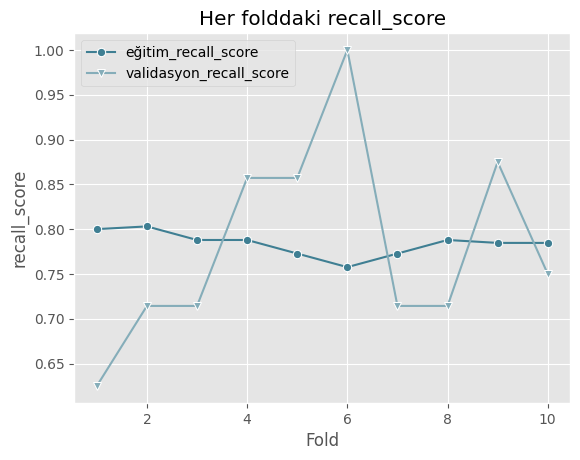

Registered model 'logistic_regression_not_scaled_model' already exists. Creating a new version of this model...
Created version '4' of model 'logistic_regression_not_scaled_model'.


In [160]:
# grid search sonrası bulunan en iyi parametreler modele eklendi.

lr = LogisticRegression(C=0.005, class_weight="balanced", penalty="l2")
with mlflow.start_run(run_name="Logistic Regression Not Scaled Model: Metric = recall"):
    skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
    lr_model, lr_final_test_recall_score, lr_recall_scores_df,lr_y_pred_test = train_and_evaluate_model(lr, X_train, y_train, X_test, y_test,recall_score, skf, plot=True)
    
    # Model metriklerin kaydedilmesi
    mlflow.log_metric("final_test_recall_score", lr_final_test_recall_score)
    
    # Modelin kaydedilmesi
    model_path = "logistic_regression_not_scaled_model"
    mlflow.sklearn.log_model(lr, model_path)
    
    # Modeli Model Registry'ye kaydetme
    mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_path}", name="logistic_regression_not_scaled_model")
    
    # Artifacts kayıt
    lr_recall_scores_df.to_csv("mlflow_model_csv_data/lr_not_scaled_recall_scores.csv", index=False)
    mlflow.log_artifact("mlflow_model_csv_data/lr_not_scaled_recall_scores.csv")

**Scaling ile model eğitim ve değerlendirmesi**

- Ortalama eğitim_recall_score sonuç: 0.88
- Ortalama validasyon_recall_score sonuç: 0.89
- Son test_recall_score sonuç: 0.90
- Validasyon scorunun eğitim scoruna göre farkının % değeri:%1.26
- Final scoreun eğitim scoruna göre farkının % değeri:%2.48
- Son test seti için oluşturulan confusion matrix:
 - [[21  5]
 - [ 1  9]]	
 - Confusion matrixde sadece 1 kişi FN yani yanlış teşhis konulmuş, TP= 9 kişi kalp hastası olarak sınıflandırılmıştır. Model amaca uygun sonuçlar üretmiştir.
 - **!!!Not: Bu sonuçlar baseline model aşamasında elde edilmiştir. Feature ekledikten sonra sonuçlar değişmiştir.**

Fold 1 eğitim_recall_score: 0.89
Fold 1 validasyon_recall_score: 1.00
Fold 2 eğitim_recall_score: 0.88
Fold 2 validasyon_recall_score: 0.86
Fold 3 eğitim_recall_score: 0.89
Fold 3 validasyon_recall_score: 0.86
Fold 4 eğitim_recall_score: 0.86
Fold 4 validasyon_recall_score: 0.86
Fold 5 eğitim_recall_score: 0.86
Fold 5 validasyon_recall_score: 1.00
Fold 6 eğitim_recall_score: 0.85
Fold 6 validasyon_recall_score: 0.86
Fold 7 eğitim_recall_score: 0.91
Fold 7 validasyon_recall_score: 0.86
Fold 8 eğitim_recall_score: 0.89
Fold 8 validasyon_recall_score: 0.86
Fold 9 eğitim_recall_score: 0.88
Fold 9 validasyon_recall_score: 1.00
Fold 10 eğitim_recall_score: 0.86
Fold 10 validasyon_recall_score: 0.75
Cross validation aşaması tamamlandı! Model eğitimine başlandı...
*******************************************
Model eğitimi tamamlandı!
*******************************************
Ortalama eğitim_recall_score sonuç: 0.88
Ortalama validasyon_recall_score sonuç: 0.89
Son test_recall_score sonuç: 0.90

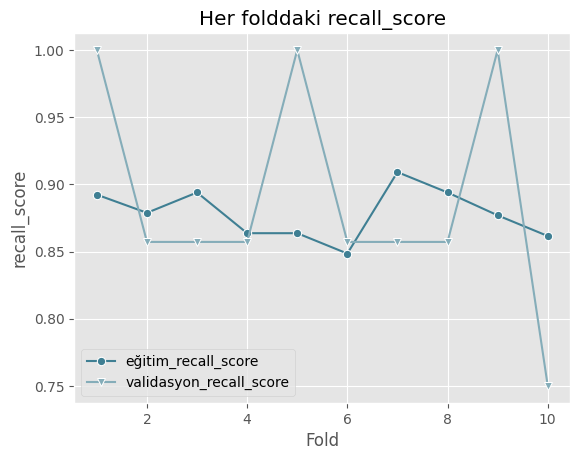

Registered model 'logistic_regression_scaled_model' already exists. Creating a new version of this model...
Created version '4' of model 'logistic_regression_scaled_model'.


In [161]:
# grid search sonrası bulunan en iyi parametreler modele eklendi.
lr = LogisticRegression(C=0.005, class_weight="balanced", penalty="l2")

lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", lr)
])

with mlflow.start_run(run_name="Logistic Regression Scaled Model: Metric = recall"):
    skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
    lr_model, lr_final_test_recall_score, lr_recall_scores_df,lr_y_pred_test = train_and_evaluate_model(lr_pipeline, X_train, y_train, X_test, y_test,recall_score, skf, plot=True)
    
    # Model metriklerin kaydedilmesi
    mlflow.log_metric("final_test_recall_score", lr_final_test_recall_score)
    
    # Modelin kaydedilmesi
    model_path = "logistic_regression_scaled_model"
    mlflow.sklearn.log_model(lr_pipeline, model_path)
    
    # Modeli Model Registry'ye kaydetme
    mlflow.register_model(model_uri=f"runs:/{mlflow.active_run().info.run_id}/{model_path}", name="logistic_regression_scaled_model")
    
    # # Artifacts kayıt
    lr_recall_scores_df.to_csv("mlflow_model_csv_data/lr_scaled_recall_scores.csv", index=False)
    mlflow.log_artifact("mlflow_model_csv_data/lr_scaled_recall_scores.csv")